In [29]:
import os
import time

import pyreadr as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

torch.manual_seed(42)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:3


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip dataverse_files.zip -d dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("dataverse_files/TEP_Faulty_Training.RData")

In [4]:
#reading test data in .R format
a3 = py.read_r("dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("dataverse_files/TEP_Faulty_Testing.RData")

In [5]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
print("Objects that are present in a3 :", a3.keys())
print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [6]:
# concatinating the train and the test dataset

# train dataframe
raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# test dataframe
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [7]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1

> ### EDA

In [8]:
features = ['xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']

In [9]:
def accuracy(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

> ### Sampling

Described in "Data Preparation for Deep Learning Models" in [that article](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

In [10]:
# 5.250.000, 10.080.000
len(raw_train), len(raw_test)

(5250000, 10080000)

In [11]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [12]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [13]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
# y_train = raw_train[raw_train['index'].isin(X_train_idx)][['index', 'faultNumber']]

X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)
# y_val = raw_train[raw_train['index'].isin(X_val_idx)][['index', 'faultNumber']]

# X_test = raw_test.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
# y_test = raw_test['faultNumber']

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

In [15]:
# X_raw_train = raw_train[raw_train['faultNumber'].isin([0, 1, 10, 20])].drop('index', axis=1)
X_raw_train = raw_train.drop('index', axis=1)
len(X_raw_train)

5250000

In [16]:
scaler_raw = StandardScaler()
scaler_raw.fit(X_raw_train[features])

X_raw_train[features] = scaler_raw.transform(X_raw_train[features])

In [17]:
class DataTEP(Dataset):

    def __init__(self, X):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')

    def __len__(self):
        return self.X.index.max() + 1
    
    def __getitem__(self, idx):
        
        features = [
       'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
        
        features = self.X.loc[idx][features].values
        target = self.X.loc[idx]['faultNumber'].unique()[0]
        
#         features = torch.tensor(features, dtype=torch.float)[-10:]
#         features = torch.tensor(features, dtype=torch.float)[:, 0].unsqueeze(-1)
#         features = torch.tensor(features, dtype=torch.float)[-50:, :30]
        features = torch.tensor(features, dtype=torch.float)[-50:, :]
#         features = torch.tensor(features, dtype=torch.float)[:, 1].unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [18]:
import gc
gc.collect()

0

In [19]:
BATCH_SIZE = 64
NUM_CLASSES = 21
NUM_EPOCHS = 120
LEARNING_RATE = 0.001

In [20]:
raw_ds = DataTEP(X_raw_train)
raw_dl = DataLoader(raw_ds, batch_size=64, shuffle=True)

train_ds = DataTEP(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = DataTEP(X_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4)

# test_ds = DataTEP(X_test, y_test)
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4)

In [21]:
def check_dl(dl):
    for (X_batch, y_batch) in tqdm(dl):
        print("min", y_batch.numpy().min())
        print("max", y_batch.numpy().max())
        print(X_batch.size(), y_batch.size())
#         print(np.bincount(y_batch.numpy()))

check_dl(train_dl)

min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 19
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 20
torch.Size([64, 50, 52]) torch.Size([64])
min 0
max 

```python
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(52, 1), return_sequences=True))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dense(300))
model_1.add(Dropout(0.5))
model_1.add(Dense(128))
model_1.add(Dense(21, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())
```

In [22]:
class Model(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.directions = True
        
        self.lstm = nn.LSTM(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.directions,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.directions+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x, _ = self.lstm(x)
        x = self.head(x[:, -1])
        
        return x

In [64]:
model = Model(NUM_LAYERS=2, INPUT_SIZE=52, HIDDEN_SIZE=256, LINEAR_SIZE=128, OUTPUT_SIZE=NUM_CLASSES, DEVICE=device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

In [59]:
# !rm -r runs

In [65]:
writer = SummaryWriter(comment='hidden_256_linear_128')

In [66]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')
#     print(f'Epoch: {epoch}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += accuracy(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for item in model.parameters():
            print(item.grad.mean())
        
        for (X_batch_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += accuracy(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            

    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch, loss_train_epoch, n_train}, mean loss val: {loss_mean_val_epoch, loss_val_epoch, n_val}")
    print(f"accuracy train: {accuracy_train_epoch, correct_train_epoch}, accuracy val: {accuracy_val_epoch, correct_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




tensor(3.2241e-06, device='cuda:3')
tensor(-2.9035e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-1.6876e-06, device='cuda:3')
tensor(-7.3878e-08, device='cuda:3')
tensor(-1.4514e-05, device='cuda:3')
tensor(-1.4514e-05, device='cuda:3')
tensor(1.1874e-06, device='cuda:3')
tensor(1.2763e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-4.5573e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-8.9682e-05, device='cuda:3')
tensor(-8.9682e-05, device='cuda:3')
tensor(7.8478e-06, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(-3.3035e-09, device='cuda:3')
tensor(-3.1931e-09, device='cuda:3')



epoch time: 22.61512851715088
mean loss train: (1.9866714141482398, 16688.039878845215, 8400), mean loss val: (1.6198762852805002, 3401.7401990890503, 2100)
accuracy train: (0.35464285714285715, 2979), accuracy val: (0.4185714285714286, 879)
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




tensor(3.0326e-06, device='cuda:3')
tensor(1.5127e-06, device='cuda:3')
tensor(-7.5196e-05, device='cuda:3')
tensor(-7.5196e-05, device='cuda:3')
tensor(-6.6958e-08, device='cuda:3')
tensor(-1.9457e-07, device='cuda:3')
tensor(-6.3052e-05, device='cuda:3')
tensor(-6.3052e-05, device='cuda:3')
tensor(-1.3711e-06, device='cuda:3')
tensor(3.5257e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-3.5534e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(6.2945e-05, device='cuda:3')
tensor(6.2945e-05, device='cuda:3')
tensor(-8.8856e-06, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(-1.0891e-09, device='cuda:3')
tensor(-3.5479e-10, device='cuda:3')



epoch time: 22.297397136688232
mean loss train: (1.6103691655113583, 13527.10099029541, 8400), mean loss val: (1.5596468630291167, 3275.258412361145, 2100)
accuracy train: (0.4413095238095238, 3707), accuracy val: (0.45571428571428574, 957)
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




tensor(1.2937e-05, device='cuda:3')
tensor(3.3783e-07, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(2.0387e-06, device='cuda:3')
tensor(4.9782e-08, device='cuda:3')
tensor(2.7912e-05, device='cuda:3')
tensor(2.7912e-05, device='cuda:3')
tensor(2.1743e-07, device='cuda:3')
tensor(-5.1158e-07, device='cuda:3')
tensor(-2.8420e-05, device='cuda:3')
tensor(-2.8420e-05, device='cuda:3')
tensor(-6.8795e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.9921e-05, device='cuda:3')
tensor(-1.9921e-05, device='cuda:3')
tensor(5.3079e-06, device='cuda:3')
tensor(-1.2417e-05, device='cuda:3')
tensor(1.9275e-09, device='cuda:3')
tensor(2.1287e-09, device='cuda:3')



epoch time: 22.175942182540894
mean loss train: (1.320831780093057, 11094.986952781677, 8400), mean loss val: (1.0021764021828061, 2104.570444583893, 2100)
accuracy train: (0.5230952380952381, 4394), accuracy val: (0.5804761904761905, 1219)
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




tensor(-5.1601e-05, device='cuda:3')
tensor(-1.5886e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(1.9072e-06, device='cuda:3')
tensor(6.5674e-08, device='cuda:3')
tensor(1.4543e-06, device='cuda:3')
tensor(1.4543e-06, device='cuda:3')
tensor(-6.6718e-08, device='cuda:3')
tensor(-2.0402e-07, device='cuda:3')
tensor(-1.0653e-05, device='cuda:3')
tensor(-1.0653e-05, device='cuda:3')
tensor(2.4863e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(8.9642e-06, device='cuda:3')
tensor(8.9642e-06, device='cuda:3')
tensor(2.3945e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-4.4127e-09, device='cuda:3')
tensor(-3.1044e-09, device='cuda:3')



epoch time: 23.356716871261597
mean loss train: (0.8790559166386014, 7384.069699764252, 8400), mean loss val: (0.8291233957381475, 1741.1591310501099, 2100)
accuracy train: (0.643452380952381, 5405), accuracy val: (0.6633333333333333, 1393)
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




tensor(1.4054e-05, device='cuda:3')
tensor(6.0356e-07, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(1.1771e-06, device='cuda:3')
tensor(-9.7809e-09, device='cuda:3')
tensor(5.4674e-05, device='cuda:3')
tensor(5.4674e-05, device='cuda:3')
tensor(-8.4432e-08, device='cuda:3')
tensor(6.3975e-08, device='cuda:3')
tensor(9.4997e-06, device='cuda:3')
tensor(9.4997e-06, device='cuda:3')
tensor(-5.0004e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.1075e-06, device='cuda:3')
tensor(-1.1075e-06, device='cuda:3')
tensor(-1.5071e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(1.9155e-09, device='cuda:3')
tensor(2.8383e-09, device='cuda:3')



epoch time: 22.521713733673096
mean loss train: (0.7483232709339687, 6285.915475845337, 8400), mean loss val: (0.7689168306723947, 1614.7253444120288, 2100)
accuracy train: (0.6919047619047619, 5812), accuracy val: (0.700952380952381, 1472)
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




tensor(-6.3272e-05, device='cuda:3')
tensor(-1.0838e-05, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(1.4537e-05, device='cuda:3')
tensor(4.6606e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-8.4265e-06, device='cuda:3')
tensor(5.5271e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-2.1639e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.6337e-05, device='cuda:3')
tensor(-4.6337e-05, device='cuda:3')
tensor(5.2997e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(2.1528e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 22.90335178375244
mean loss train: (0.8744441359383719, 7345.330741882324, 8400), mean loss val: (0.8553082319242614, 1796.1472870409489, 2100)
accuracy train: (0.6673809523809524, 5606), accuracy val: (0.6480952380952381, 1361)
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




tensor(-0.0005, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(0.0150, device='cuda:3')
tensor(0.0150, device='cuda:3')
tensor(-2.5024e-05, device='cuda:3')
tensor(8.5605e-09, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(-4.5972e-07, device='cuda:3')
tensor(-9.8261e-07, device='cuda:3')
tensor(3.1641e-05, device='cuda:3')
tensor(3.1641e-05, device='cuda:3')
tensor(-2.0189e-06, device='cuda:3')
tensor(0., device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0062, device='cuda:3')
tensor(5.3982e-09, device='cuda:3')
tensor(2.7496e-09, device='cuda:3')



epoch time: 23.51434636116028
mean loss train: (0.7489220339911324, 6290.945085525513, 8400), mean loss val: (0.8697640886760893, 1826.5045862197876, 2100)
accuracy train: (0.7047619047619048, 5920), accuracy val: (0.6942857142857143, 1458)
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




tensor(1.3645e-05, device='cuda:3')
tensor(1.2766e-06, device='cuda:3')
tensor(0.0018, device='cuda:3')
tensor(0.0018, device='cuda:3')
tensor(9.7330e-07, device='cuda:3')
tensor(2.5041e-08, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-5.8992e-08, device='cuda:3')
tensor(-1.7818e-06, device='cuda:3')
tensor(4.2955e-05, device='cuda:3')
tensor(4.2955e-05, device='cuda:3')
tensor(-2.9200e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-2.9720e-05, device='cuda:3')
tensor(0.0016, device='cuda:3')
tensor(6.4433e-09, device='cuda:3')
tensor(3.9027e-09, device='cuda:3')



epoch time: 23.137970447540283
mean loss train: (0.774183661142985, 6503.142753601074, 8400), mean loss val: (0.5754041904778707, 1208.3488000035286, 2100)
accuracy train: (0.7089285714285715, 5955), accuracy val: (0.7628571428571429, 1602)
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




tensor(-3.0201e-06, device='cuda:3')
tensor(-1.5150e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-4.8526e-06, device='cuda:3')
tensor(-1.8273e-09, device='cuda:3')
tensor(-3.5464e-05, device='cuda:3')
tensor(-3.5464e-05, device='cuda:3')
tensor(-1.0614e-08, device='cuda:3')
tensor(-4.3911e-07, device='cuda:3')
tensor(1.1166e-05, device='cuda:3')
tensor(1.1166e-05, device='cuda:3')
tensor(-4.1274e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.6027e-05, device='cuda:3')
tensor(-4.6027e-05, device='cuda:3')
tensor(5.2488e-06, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-1.7547e-09, device='cuda:3')
tensor(-1.5966e-09, device='cuda:3')



epoch time: 23.995442152023315
mean loss train: (0.5646765744118464, 4743.283225059509, 8400), mean loss val: (0.5695014240641502, 1195.9529905347154, 2100)
accuracy train: (0.7694047619047619, 6463), accuracy val: (0.7642857142857142, 1605)
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




tensor(7.7470e-06, device='cuda:3')
tensor(-6.1859e-07, device='cuda:3')
tensor(2.1045e-05, device='cuda:3')
tensor(2.1045e-05, device='cuda:3')
tensor(-5.1238e-06, device='cuda:3')
tensor(4.6356e-07, device='cuda:3')
tensor(4.4617e-05, device='cuda:3')
tensor(4.4617e-05, device='cuda:3')
tensor(4.1890e-08, device='cuda:3')
tensor(2.3747e-06, device='cuda:3')
tensor(-9.6107e-05, device='cuda:3')
tensor(-9.6107e-05, device='cuda:3')
tensor(-2.7536e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.8622e-05, device='cuda:3')
tensor(-2.8622e-05, device='cuda:3')
tensor(4.6737e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(5.5837e-09, device='cuda:3')
tensor(3.9027e-09, device='cuda:3')



epoch time: 22.913631439208984
mean loss train: (0.5486988969076247, 4609.070734024048, 8400), mean loss val: (0.5178440292818206, 1087.4724614918232, 2100)
accuracy train: (0.7655952380952381, 6431), accuracy val: (0.7795238095238095, 1637)
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




tensor(6.9161e-05, device='cuda:3')
tensor(2.5189e-06, device='cuda:3')
tensor(-0.0013, device='cuda:3')
tensor(-0.0013, device='cuda:3')
tensor(1.8066e-05, device='cuda:3')
tensor(-1.4648e-06, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(3.7711e-07, device='cuda:3')
tensor(-4.4733e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(3.5889e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.9960e-05, device='cuda:3')
tensor(-1.9960e-05, device='cuda:3')
tensor(1.6635e-05, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(3.4437e-12, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 23.12843370437622
mean loss train: (0.48184901555379234, 4047.5317306518555, 8400), mean loss val: (0.5746648227600825, 1206.796127796173, 2100)
accuracy train: (0.7901190476190476, 6637), accuracy val: (0.7690476190476191, 1615)
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




tensor(4.2294e-07, device='cuda:3')
tensor(-1.0514e-07, device='cuda:3')
tensor(1.9124e-05, device='cuda:3')
tensor(1.9124e-05, device='cuda:3')
tensor(-7.2201e-07, device='cuda:3')
tensor(-6.1693e-09, device='cuda:3')
tensor(6.8793e-06, device='cuda:3')
tensor(6.8793e-06, device='cuda:3')
tensor(1.8734e-07, device='cuda:3')
tensor(2.8423e-07, device='cuda:3')
tensor(-1.9733e-05, device='cuda:3')
tensor(-1.9733e-05, device='cuda:3')
tensor(-1.5262e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.5114e-07, device='cuda:3')
tensor(1.5114e-07, device='cuda:3')
tensor(3.5280e-07, device='cuda:3')
tensor(-5.1702e-05, device='cuda:3')
tensor(1.0850e-08, device='cuda:3')
tensor(6.7410e-09, device='cuda:3')



epoch time: 23.391239643096924
mean loss train: (0.44812728291466125, 3764.2691764831543, 8400), mean loss val: (0.47876911049793264, 1005.4151320456585, 2100)
accuracy train: (0.8013095238095238, 6731), accuracy val: (0.7942857142857143, 1668)
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




tensor(-0.0001, device='cuda:3')
tensor(2.6151e-06, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(-4.2519e-06, device='cuda:3')
tensor(2.9153e-07, device='cuda:3')
tensor(-1.6805e-05, device='cuda:3')
tensor(-1.6805e-05, device='cuda:3')
tensor(-1.5533e-08, device='cuda:3')
tensor(1.0646e-06, device='cuda:3')
tensor(-4.3852e-05, device='cuda:3')
tensor(-4.3852e-05, device='cuda:3')
tensor(2.0445e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-7.4180e-05, device='cuda:3')
tensor(-7.4180e-05, device='cuda:3')
tensor(1.6733e-06, device='cuda:3')
tensor(-1.8651e-05, device='cuda:3')
tensor(-4.3083e-09, device='cuda:3')
tensor(-4.1688e-09, device='cuda:3')



epoch time: 23.273067474365234
mean loss train: (0.5156060593468802, 4331.090898513794, 8400), mean loss val: (0.4628677738279138, 972.0223250386189, 2100)
accuracy train: (0.7817857142857143, 6567), accuracy val: (0.7995238095238095, 1679)
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




tensor(4.0288e-06, device='cuda:3')
tensor(1.2114e-05, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(3.4453e-06, device='cuda:3')
tensor(-2.3353e-07, device='cuda:3')
tensor(4.8806e-05, device='cuda:3')
tensor(4.8806e-05, device='cuda:3')
tensor(-1.1682e-07, device='cuda:3')
tensor(-6.7680e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-4.5924e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.2464e-05, device='cuda:3')
tensor(-4.2464e-05, device='cuda:3')
tensor(1.2332e-05, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-2.8448e-10, device='cuda:3')
tensor(-8.8697e-11, device='cuda:3')



epoch time: 22.566442489624023
mean loss train: (0.4442558998153323, 3731.7495584487915, 8400), mean loss val: (0.43347701163563346, 910.3017244348302, 2100)
accuracy train: (0.7995238095238095, 6716), accuracy val: (0.7971428571428572, 1674)
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




tensor(-4.9790e-06, device='cuda:3')
tensor(1.6515e-07, device='cuda:3')
tensor(8.4566e-05, device='cuda:3')
tensor(8.4566e-05, device='cuda:3')
tensor(-6.1851e-06, device='cuda:3')
tensor(-1.5589e-07, device='cuda:3')
tensor(7.9728e-05, device='cuda:3')
tensor(7.9728e-05, device='cuda:3')
tensor(1.5468e-07, device='cuda:3')
tensor(7.7453e-07, device='cuda:3')
tensor(-5.6490e-05, device='cuda:3')
tensor(-5.6490e-05, device='cuda:3')
tensor(-2.2127e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.2758e-05, device='cuda:3')
tensor(-3.2758e-05, device='cuda:3')
tensor(5.1486e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(6.0854e-09, device='cuda:3')
tensor(3.9027e-09, device='cuda:3')



epoch time: 22.91244125366211
mean loss train: (0.4131460262480236, 3470.4266204833984, 8400), mean loss val: (0.4160655237379944, 873.7375998497882, 2100)
accuracy train: (0.8048809523809524, 6761), accuracy val: (0.8033333333333333, 1687)
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




tensor(-2.9475e-07, device='cuda:3')
tensor(-1.9184e-07, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(-2.2488e-07, device='cuda:3')
tensor(5.9563e-08, device='cuda:3')
tensor(2.5982e-06, device='cuda:3')
tensor(2.5982e-06, device='cuda:3')
tensor(3.8318e-07, device='cuda:3')
tensor(6.4940e-07, device='cuda:3')
tensor(-3.0041e-05, device='cuda:3')
tensor(-3.0041e-05, device='cuda:3')
tensor(-4.8893e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.9777e-05, device='cuda:3')
tensor(-2.9777e-05, device='cuda:3')
tensor(-9.5462e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(4.8470e-09, device='cuda:3')
tensor(2.7496e-09, device='cuda:3')



epoch time: 23.07418990135193
mean loss train: (0.3986330687999725, 3348.5177779197693, 8400), mean loss val: (0.43221684955415096, 907.6553840637171, 2100)
accuracy train: (0.8117857142857143, 6819), accuracy val: (0.8038095238095239, 1688)
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




tensor(-7.0089e-06, device='cuda:3')
tensor(-1.5970e-06, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(-6.2539e-07, device='cuda:3')
tensor(6.4027e-08, device='cuda:3')
tensor(-1.3201e-05, device='cuda:3')
tensor(-1.3201e-05, device='cuda:3')
tensor(-7.8756e-08, device='cuda:3')
tensor(6.6902e-07, device='cuda:3')
tensor(-2.4551e-05, device='cuda:3')
tensor(-2.4551e-05, device='cuda:3')
tensor(-9.0637e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.7830e-05, device='cuda:3')
tensor(-1.7830e-05, device='cuda:3')
tensor(5.2691e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(3.9775e-10, device='cuda:3')
tensor(-1.4192e-09, device='cuda:3')



epoch time: 23.597649097442627
mean loss train: (0.4303448494275411, 3614.896735191345, 8400), mean loss val: (0.3835845910793259, 805.5276412665844, 2100)
accuracy train: (0.8069047619047619, 6778), accuracy val: (0.8142857142857143, 1710)
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




tensor(2.4079e-07, device='cuda:3')
tensor(3.1662e-07, device='cuda:3')
tensor(1.4095e-05, device='cuda:3')
tensor(1.4095e-05, device='cuda:3')
tensor(1.7156e-07, device='cuda:3')
tensor(8.2230e-09, device='cuda:3')
tensor(2.2060e-06, device='cuda:3')
tensor(2.2060e-06, device='cuda:3')
tensor(-1.3916e-08, device='cuda:3')
tensor(2.2089e-07, device='cuda:3')
tensor(2.8808e-07, device='cuda:3')
tensor(2.8808e-07, device='cuda:3')
tensor(-2.0621e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.3657e-05, device='cuda:3')
tensor(1.3657e-05, device='cuda:3')
tensor(-2.4393e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-2.2523e-09, device='cuda:3')
tensor(-1.9513e-09, device='cuda:3')



epoch time: 22.763099431991577
mean loss train: (0.36872199194771904, 3097.26473236084, 8400), mean loss val: (0.3692573315712313, 775.4403962995857, 2100)
accuracy train: (0.8192857142857143, 6882), accuracy val: (0.8180952380952381, 1718)
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




tensor(4.9712e-07, device='cuda:3')
tensor(-4.4877e-08, device='cuda:3')
tensor(5.1762e-05, device='cuda:3')
tensor(5.1762e-05, device='cuda:3')
tensor(6.2572e-07, device='cuda:3')
tensor(3.3331e-08, device='cuda:3')
tensor(-2.3215e-06, device='cuda:3')
tensor(-2.3215e-06, device='cuda:3')
tensor(-1.7069e-07, device='cuda:3')
tensor(3.9743e-07, device='cuda:3')
tensor(-6.9144e-06, device='cuda:3')
tensor(-6.9144e-06, device='cuda:3')
tensor(8.7953e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.2333e-05, device='cuda:3')
tensor(-1.2333e-05, device='cuda:3')
tensor(2.2021e-07, device='cuda:3')
tensor(-9.8338e-05, device='cuda:3')
tensor(2.3033e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 23.55901312828064
mean loss train: (0.35230751165321894, 2959.383097887039, 8400), mean loss val: (0.3757517962229239, 789.0787720681401, 2100)
accuracy train: (0.8227380952380953, 6911), accuracy val: (0.8123809523809524, 1706)
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




tensor(-6.8601e-07, device='cuda:3')
tensor(2.9962e-09, device='cuda:3')
tensor(-4.7053e-05, device='cuda:3')
tensor(-4.7053e-05, device='cuda:3')
tensor(1.2675e-06, device='cuda:3')
tensor(2.9893e-08, device='cuda:3')
tensor(-1.2870e-05, device='cuda:3')
tensor(-1.2870e-05, device='cuda:3')
tensor(-6.6331e-08, device='cuda:3')
tensor(-1.0062e-08, device='cuda:3')
tensor(9.3695e-06, device='cuda:3')
tensor(9.3695e-06, device='cuda:3')
tensor(9.7220e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.3801e-05, device='cuda:3')
tensor(-2.3801e-05, device='cuda:3')
tensor(2.5283e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(6.8100e-09, device='cuda:3')
tensor(4.9671e-09, device='cuda:3')



epoch time: 23.711247205734253
mean loss train: (0.3622787617501758, 3043.141598701477, 8400), mean loss val: (0.370592053844538, 778.2433130735299, 2100)
accuracy train: (0.8194047619047619, 6883), accuracy val: (0.8195238095238095, 1721)
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




tensor(-3.6851e-06, device='cuda:3')
tensor(-3.8081e-08, device='cuda:3')
tensor(-3.2679e-05, device='cuda:3')
tensor(-3.2679e-05, device='cuda:3')
tensor(7.4656e-07, device='cuda:3')
tensor(5.1550e-09, device='cuda:3')
tensor(1.3802e-05, device='cuda:3')
tensor(1.3802e-05, device='cuda:3')
tensor(4.5416e-08, device='cuda:3')
tensor(-2.7663e-07, device='cuda:3')
tensor(5.3769e-06, device='cuda:3')
tensor(5.3769e-06, device='cuda:3')
tensor(-8.4113e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.0825e-06, device='cuda:3')
tensor(4.0825e-06, device='cuda:3')
tensor(-5.7392e-08, device='cuda:3')
tensor(-3.8806e-06, device='cuda:3')
tensor(-4.9725e-09, device='cuda:3')
tensor(-2.9935e-09, device='cuda:3')



epoch time: 22.388449668884277
mean loss train: (0.3410018145470392, 2864.4152421951294, 8400), mean loss val: (0.3511696424937275, 737.4562492368277, 2100)
accuracy train: (0.8270238095238095, 6947), accuracy val: (0.8195238095238095, 1721)
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




tensor(1.0043e-06, device='cuda:3')
tensor(-1.8887e-07, device='cuda:3')
tensor(-1.6228e-05, device='cuda:3')
tensor(-1.6228e-05, device='cuda:3')
tensor(-2.7386e-07, device='cuda:3')
tensor(5.5192e-09, device='cuda:3')
tensor(2.0638e-07, device='cuda:3')
tensor(2.0638e-07, device='cuda:3')
tensor(1.4417e-08, device='cuda:3')
tensor(-6.8380e-09, device='cuda:3')
tensor(1.2788e-06, device='cuda:3')
tensor(1.2788e-06, device='cuda:3')
tensor(3.7159e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.5210e-07, device='cuda:3')
tensor(-6.5210e-07, device='cuda:3')
tensor(-4.1575e-07, device='cuda:3')
tensor(3.5550e-05, device='cuda:3')
tensor(-7.8421e-09, device='cuda:3')
tensor(-6.0314e-09, device='cuda:3')



epoch time: 22.321569681167603
mean loss train: (0.3300975544112069, 2772.819457054138, 8400), mean loss val: (0.3381686939512119, 710.154257297545, 2100)
accuracy train: (0.8297619047619048, 6970), accuracy val: (0.8357142857142857, 1755)
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




tensor(3.6483e-07, device='cuda:3')
tensor(8.7450e-08, device='cuda:3')
tensor(-3.6507e-05, device='cuda:3')
tensor(-3.6507e-05, device='cuda:3')
tensor(-1.8134e-07, device='cuda:3')
tensor(5.3419e-09, device='cuda:3')
tensor(-4.3175e-06, device='cuda:3')
tensor(-4.3175e-06, device='cuda:3')
tensor(4.3713e-08, device='cuda:3')
tensor(1.8938e-07, device='cuda:3')
tensor(-4.8041e-06, device='cuda:3')
tensor(-4.8041e-06, device='cuda:3')
tensor(2.1520e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.7485e-06, device='cuda:3')
tensor(-4.7485e-06, device='cuda:3')
tensor(1.1537e-06, device='cuda:3')
tensor(-7.1929e-05, device='cuda:3')
tensor(5.2910e-09, device='cuda:3')
tensor(3.5479e-09, device='cuda:3')



epoch time: 22.5250883102417
mean loss train: (0.3189582521574838, 2679.2493181228638, 8400), mean loss val: (0.3713899135588491, 779.9188184735831, 2100)
accuracy train: (0.8371428571428572, 7032), accuracy val: (0.8228571428571428, 1728)
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




tensor(9.6290e-06, device='cuda:3')
tensor(5.0419e-06, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(5.0380e-07, device='cuda:3')
tensor(-1.7746e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-3.1384e-07, device='cuda:3')
tensor(9.9218e-08, device='cuda:3')
tensor(3.2768e-05, device='cuda:3')
tensor(3.2768e-05, device='cuda:3')
tensor(2.2047e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.6997e-05, device='cuda:3')
tensor(-4.6997e-05, device='cuda:3')
tensor(3.4191e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-1.8612e-09, device='cuda:3')
tensor(-1.4192e-09, device='cuda:3')



epoch time: 23.303394079208374
mean loss train: (0.31471809066477274, 2643.631961584091, 8400), mean loss val: (0.32560607001895864, 683.7727470398131, 2100)
accuracy train: (0.8392857142857143, 7050), accuracy val: (0.8380952380952381, 1760)
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.001




tensor(1.7939e-05, device='cuda:3')
tensor(-6.4489e-07, device='cuda:3')
tensor(0.0008, device='cuda:3')
tensor(0.0008, device='cuda:3')
tensor(-1.6554e-05, device='cuda:3')
tensor(-2.4241e-06, device='cuda:3')
tensor(-5.7738e-05, device='cuda:3')
tensor(-5.7738e-05, device='cuda:3')
tensor(-2.6196e-06, device='cuda:3')
tensor(-1.8935e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-5.3132e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(8.3466e-06, device='cuda:3')
tensor(8.3466e-06, device='cuda:3')
tensor(8.6403e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-2.6026e-09, device='cuda:3')
tensor(-1.2418e-09, device='cuda:3')



epoch time: 23.11379361152649
mean loss train: (0.3283925099032266, 2758.4970831871033, 8400), mean loss val: (0.4419582424845084, 928.1123092174676, 2100)
accuracy train: (0.8345238095238096, 7010), accuracy val: (0.8171428571428572, 1716)
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.001




tensor(3.0511e-06, device='cuda:3')
tensor(4.6796e-07, device='cuda:3')
tensor(-5.9383e-05, device='cuda:3')
tensor(-5.9383e-05, device='cuda:3')
tensor(-8.8405e-07, device='cuda:3')
tensor(2.3989e-10, device='cuda:3')
tensor(-4.2566e-06, device='cuda:3')
tensor(-4.2566e-06, device='cuda:3')
tensor(-1.0710e-08, device='cuda:3')
tensor(5.5458e-08, device='cuda:3')
tensor(3.4126e-06, device='cuda:3')
tensor(3.4126e-06, device='cuda:3')
tensor(-2.5025e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-9.2398e-06, device='cuda:3')
tensor(-9.2398e-06, device='cuda:3')
tensor(6.1668e-07, device='cuda:3')
tensor(6.5177e-06, device='cuda:3')
tensor(9.9063e-09, device='cuda:3')
tensor(4.6123e-09, device='cuda:3')



epoch time: 23.659911632537842
mean loss train: (0.35487241097858974, 2980.928252220154, 8400), mean loss val: (0.5999707567123793, 1259.9385890959966, 2100)
accuracy train: (0.8333333333333334, 7000), accuracy val: (0.8061904761904762, 1693)
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.001




tensor(7.5914e-08, device='cuda:3')
tensor(1.1130e-08, device='cuda:3')
tensor(-1.2682e-06, device='cuda:3')
tensor(-1.2682e-06, device='cuda:3')
tensor(-8.5443e-09, device='cuda:3')
tensor(-9.5673e-10, device='cuda:3')
tensor(1.0490e-07, device='cuda:3')
tensor(1.0490e-07, device='cuda:3')
tensor(-1.2192e-09, device='cuda:3')
tensor(1.3977e-08, device='cuda:3')
tensor(-3.8017e-07, device='cuda:3')
tensor(-3.8017e-07, device='cuda:3')
tensor(-1.9479e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.5873e-07, device='cuda:3')
tensor(-1.5873e-07, device='cuda:3')
tensor(3.9489e-08, device='cuda:3')
tensor(-7.5638e-06, device='cuda:3')
tensor(5.5067e-09, device='cuda:3')
tensor(2.2549e-09, device='cuda:3')



epoch time: 23.0830237865448
mean loss train: (0.3457923218749818, 2904.6555037498474, 8400), mean loss val: (0.34267377558031253, 719.6149287186563, 2100)
accuracy train: (0.8378571428571429, 7038), accuracy val: (0.8342857142857143, 1752)
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.001




tensor(-1.0433e-05, device='cuda:3')
tensor(7.4902e-07, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-7.3779e-07, device='cuda:3')
tensor(6.2507e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-5.5560e-07, device='cuda:3')
tensor(-1.1645e-06, device='cuda:3')
tensor(9.9107e-05, device='cuda:3')
tensor(9.9107e-05, device='cuda:3')
tensor(-1.1056e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.0494e-05, device='cuda:3')
tensor(-3.0494e-05, device='cuda:3')
tensor(1.2215e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(2.0375e-09, device='cuda:3')
tensor(2.1287e-09, device='cuda:3')



epoch time: 23.687522411346436
mean loss train: (0.3732855301811582, 3135.5984535217285, 8400), mean loss val: (0.419631142275674, 881.2253987789154, 2100)
accuracy train: (0.825595238095238, 6935), accuracy val: (0.8142857142857143, 1710)
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.001




tensor(-2.2880e-07, device='cuda:3')
tensor(-6.6700e-09, device='cuda:3')
tensor(1.0289e-05, device='cuda:3')
tensor(1.0289e-05, device='cuda:3')
tensor(5.0532e-07, device='cuda:3')
tensor(2.6747e-09, device='cuda:3')
tensor(-6.9614e-06, device='cuda:3')
tensor(-6.9614e-06, device='cuda:3')
tensor(-2.7964e-08, device='cuda:3')
tensor(1.9531e-08, device='cuda:3')
tensor(-2.1090e-06, device='cuda:3')
tensor(-2.1090e-06, device='cuda:3')
tensor(5.0155e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.8850e-06, device='cuda:3')
tensor(-2.8850e-06, device='cuda:3')
tensor(2.8449e-07, device='cuda:3')
tensor(-5.0242e-05, device='cuda:3')
tensor(5.1963e-10, device='cuda:3')
tensor(3.3262e-10, device='cuda:3')



epoch time: 23.050450563430786
mean loss train: (0.34534001949287596, 2900.856163740158, 8400), mean loss val: (0.3160657526189018, 663.7380804996938, 2100)
accuracy train: (0.835952380952381, 7022), accuracy val: (0.8438095238095238, 1772)
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.001




tensor(-2.6565e-07, device='cuda:3')
tensor(-1.9051e-07, device='cuda:3')
tensor(2.4060e-05, device='cuda:3')
tensor(2.4060e-05, device='cuda:3')
tensor(1.6816e-06, device='cuda:3')
tensor(-6.3817e-09, device='cuda:3')
tensor(9.9504e-06, device='cuda:3')
tensor(9.9504e-06, device='cuda:3')
tensor(2.1296e-08, device='cuda:3')
tensor(-7.6418e-09, device='cuda:3')
tensor(5.3424e-06, device='cuda:3')
tensor(5.3424e-06, device='cuda:3')
tensor(-1.5902e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.1250e-06, device='cuda:3')
tensor(4.1250e-06, device='cuda:3')
tensor(-4.9626e-07, device='cuda:3')
tensor(4.3527e-05, device='cuda:3')
tensor(4.4084e-09, device='cuda:3')
tensor(3.0157e-09, device='cuda:3')



epoch time: 23.236196756362915
mean loss train: (0.29406216939290364, 2470.1222229003906, 8400), mean loss val: (0.29694155766584335, 623.577271098271, 2100)
accuracy train: (0.8473809523809523, 7118), accuracy val: (0.8495238095238096, 1784)
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.0005




tensor(-0.0001, device='cuda:3')
tensor(1.1652e-06, device='cuda:3')
tensor(0.0043, device='cuda:3')
tensor(0.0043, device='cuda:3')
tensor(-1.9886e-05, device='cuda:3')
tensor(-6.0173e-07, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(3.7234e-07, device='cuda:3')
tensor(1.4405e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-2.0993e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-6.0935e-06, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(1.8680e-09, device='cuda:3')
tensor(2.1287e-09, device='cuda:3')



epoch time: 23.536776781082153
mean loss train: (0.28272598153068906, 2374.898244857788, 8400), mean loss val: (0.31308012656157924, 657.4682657793164, 2100)
accuracy train: (0.8566666666666667, 7196), accuracy val: (0.8452380952380952, 1775)
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.0005




tensor(-2.0153e-07, device='cuda:3')
tensor(9.6189e-09, device='cuda:3')
tensor(-3.5510e-06, device='cuda:3')
tensor(-3.5510e-06, device='cuda:3')
tensor(3.8819e-08, device='cuda:3')
tensor(-1.9639e-09, device='cuda:3')
tensor(3.6784e-07, device='cuda:3')
tensor(3.6784e-07, device='cuda:3')
tensor(-6.7921e-09, device='cuda:3')
tensor(-1.9713e-08, device='cuda:3')
tensor(1.3595e-06, device='cuda:3')
tensor(1.3595e-06, device='cuda:3')
tensor(1.4569e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.3357e-06, device='cuda:3')
tensor(-1.3357e-06, device='cuda:3')
tensor(-1.4012e-07, device='cuda:3')
tensor(1.3386e-06, device='cuda:3')
tensor(-1.1210e-09, device='cuda:3')
tensor(-1.7739e-09, device='cuda:3')



epoch time: 22.454364776611328
mean loss train: (0.2823315398466019, 2371.5849347114563, 8400), mean loss val: (0.31057431924899687, 652.2060704228934, 2100)
accuracy train: (0.8551190476190477, 7183), accuracy val: (0.8471428571428572, 1779)
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.0005




tensor(1.6669e-06, device='cuda:3')
tensor(-1.3867e-07, device='cuda:3')
tensor(4.5501e-05, device='cuda:3')
tensor(4.5501e-05, device='cuda:3')
tensor(-4.1217e-07, device='cuda:3')
tensor(1.7962e-08, device='cuda:3')
tensor(-2.2710e-06, device='cuda:3')
tensor(-2.2710e-06, device='cuda:3')
tensor(2.4943e-08, device='cuda:3')
tensor(1.2002e-07, device='cuda:3')
tensor(-1.0772e-05, device='cuda:3')
tensor(-1.0772e-05, device='cuda:3')
tensor(-2.2083e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.0976e-06, device='cuda:3')
tensor(2.0976e-06, device='cuda:3')
tensor(-1.0985e-08, device='cuda:3')
tensor(-2.6693e-06, device='cuda:3')
tensor(2.9931e-09, device='cuda:3')
tensor(2.4170e-09, device='cuda:3')



epoch time: 23.6446270942688
mean loss train: (0.2783919495911825, 2338.4923765659332, 8400), mean loss val: (0.30528942789358554, 641.1077985765296, 2100)
accuracy train: (0.851547619047619, 7153), accuracy val: (0.8457142857142858, 1776)
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.0005




tensor(-3.1340e-06, device='cuda:3')
tensor(-1.3191e-07, device='cuda:3')
tensor(1.8681e-06, device='cuda:3')
tensor(1.8681e-06, device='cuda:3')
tensor(4.8482e-07, device='cuda:3')
tensor(1.2068e-08, device='cuda:3')
tensor(-2.9004e-06, device='cuda:3')
tensor(-2.9004e-06, device='cuda:3')
tensor(-4.9188e-08, device='cuda:3')
tensor(-1.0461e-07, device='cuda:3')
tensor(1.2246e-05, device='cuda:3')
tensor(1.2246e-05, device='cuda:3')
tensor(6.0681e-10, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.3270e-06, device='cuda:3')
tensor(4.3270e-06, device='cuda:3')
tensor(-7.8451e-07, device='cuda:3')
tensor(5.7875e-05, device='cuda:3')
tensor(-1.5195e-10, device='cuda:3')
tensor(6.6523e-10, device='cuda:3')



epoch time: 22.320436477661133
mean loss train: (0.2736292520023528, 2298.485716819763, 8400), mean loss val: (0.2932503645758455, 615.8257656092755, 2100)
accuracy train: (0.8563095238095239, 7193), accuracy val: (0.8485714285714285, 1782)
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.0005




tensor(4.0229e-07, device='cuda:3')
tensor(-1.3129e-08, device='cuda:3')
tensor(-1.5631e-05, device='cuda:3')
tensor(-1.5631e-05, device='cuda:3')
tensor(-4.2088e-07, device='cuda:3')
tensor(5.4544e-09, device='cuda:3')
tensor(3.3300e-06, device='cuda:3')
tensor(3.3300e-06, device='cuda:3')
tensor(-5.2326e-08, device='cuda:3')
tensor(-1.1269e-07, device='cuda:3')
tensor(1.5421e-05, device='cuda:3')
tensor(1.5421e-05, device='cuda:3')
tensor(-6.5224e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-5.8283e-06, device='cuda:3')
tensor(-5.8283e-06, device='cuda:3')
tensor(4.8927e-07, device='cuda:3')
tensor(-3.3739e-05, device='cuda:3')
tensor(3.4998e-09, device='cuda:3')
tensor(3.1931e-09, device='cuda:3')



epoch time: 23.643292903900146
mean loss train: (0.2680882813816979, 2251.941563606262, 8400), mean loss val: (0.2942284948485169, 617.8798391818855, 2100)
accuracy train: (0.8623809523809524, 7244), accuracy val: (0.8471428571428572, 1779)
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.0005




tensor(1.8923e-06, device='cuda:3')
tensor(-3.1244e-07, device='cuda:3')
tensor(-4.1823e-05, device='cuda:3')
tensor(-4.1823e-05, device='cuda:3')
tensor(1.6076e-06, device='cuda:3')
tensor(8.1273e-08, device='cuda:3')
tensor(-3.5210e-05, device='cuda:3')
tensor(-3.5210e-05, device='cuda:3')
tensor(-8.2554e-08, device='cuda:3')
tensor(-2.3519e-07, device='cuda:3')
tensor(3.0670e-05, device='cuda:3')
tensor(3.0670e-05, device='cuda:3')
tensor(2.5885e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.1065e-05, device='cuda:3')
tensor(-1.1065e-05, device='cuda:3')
tensor(6.3808e-07, device='cuda:3')
tensor(-8.2521e-05, device='cuda:3')
tensor(4.9106e-09, device='cuda:3')
tensor(2.1287e-09, device='cuda:3')



epoch time: 23.180408239364624
mean loss train: (0.2689536269505819, 2259.2104663848877, 8400), mean loss val: (0.3093026387120508, 649.5355412953068, 2100)
accuracy train: (0.8609523809523809, 7232), accuracy val: (0.8495238095238096, 1784)
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.0005




tensor(-8.2886e-07, device='cuda:3')
tensor(4.3526e-08, device='cuda:3')
tensor(-1.9403e-05, device='cuda:3')
tensor(-1.9403e-05, device='cuda:3')
tensor(8.0463e-07, device='cuda:3')
tensor(4.5832e-08, device='cuda:3')
tensor(-1.1261e-05, device='cuda:3')
tensor(-1.1261e-05, device='cuda:3')
tensor(-8.5240e-08, device='cuda:3')
tensor(-2.1353e-07, device='cuda:3')
tensor(2.1825e-05, device='cuda:3')
tensor(2.1825e-05, device='cuda:3')
tensor(2.6503e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.8125e-06, device='cuda:3')
tensor(-6.8125e-06, device='cuda:3')
tensor(1.1221e-06, device='cuda:3')
tensor(-9.5355e-05, device='cuda:3')
tensor(1.4019e-09, device='cuda:3')
tensor(5.3218e-10, device='cuda:3')



epoch time: 22.86428713798523
mean loss train: (0.26804183698835826, 2251.5514307022095, 8400), mean loss val: (0.29353503817602317, 616.4235801696486, 2100)
accuracy train: (0.8602380952380952, 7226), accuracy val: (0.8457142857142858, 1776)
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.0005




tensor(-1.3452e-06, device='cuda:3')
tensor(4.6775e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-5.3170e-08, device='cuda:3')
tensor(3.9005e-08, device='cuda:3')
tensor(-2.2346e-05, device='cuda:3')
tensor(-2.2346e-05, device='cuda:3')
tensor(-2.5224e-08, device='cuda:3')
tensor(-4.3283e-07, device='cuda:3')
tensor(3.3752e-05, device='cuda:3')
tensor(3.3752e-05, device='cuda:3')
tensor(-3.6356e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.4368e-06, device='cuda:3')
tensor(4.4368e-06, device='cuda:3')
tensor(1.6250e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(6.5735e-09, device='cuda:3')
tensor(4.0801e-09, device='cuda:3')



epoch time: 22.78714656829834
mean loss train: (0.2685970291069576, 2256.2150444984436, 8400), mean loss val: (0.29554174059914656, 620.6376552582078, 2100)
accuracy train: (0.8575, 7203), accuracy val: (0.8447619047619047, 1774)
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.0005




tensor(-3.2441e-06, device='cuda:3')
tensor(-7.4964e-07, device='cuda:3')
tensor(9.8195e-05, device='cuda:3')
tensor(9.8195e-05, device='cuda:3')
tensor(3.3597e-06, device='cuda:3')
tensor(-9.8808e-10, device='cuda:3')
tensor(-4.2656e-05, device='cuda:3')
tensor(-4.2656e-05, device='cuda:3')
tensor(9.0543e-08, device='cuda:3')
tensor(-5.6350e-08, device='cuda:3')
tensor(-3.6609e-05, device='cuda:3')
tensor(-3.6609e-05, device='cuda:3')
tensor(-7.7762e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.8896e-05, device='cuda:3')
tensor(1.8896e-05, device='cuda:3')
tensor(4.3658e-07, device='cuda:3')
tensor(-3.3501e-05, device='cuda:3')
tensor(4.1151e-09, device='cuda:3')
tensor(3.1931e-09, device='cuda:3')



epoch time: 22.752359628677368
mean loss train: (0.2706364505631583, 2273.34618473053, 8400), mean loss val: (0.3247516879580161, 681.9785447118338, 2100)
accuracy train: (0.8627380952380952, 7247), accuracy val: (0.8476190476190476, 1780)
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.0005




tensor(1.9284e-05, device='cuda:3')
tensor(-1.4070e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(1.8074e-06, device='cuda:3')
tensor(7.2912e-08, device='cuda:3')
tensor(-3.7612e-05, device='cuda:3')
tensor(-3.7612e-05, device='cuda:3')
tensor(3.6898e-08, device='cuda:3')
tensor(1.1425e-07, device='cuda:3')
tensor(5.2363e-05, device='cuda:3')
tensor(5.2363e-05, device='cuda:3')
tensor(3.1067e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.6624e-06, device='cuda:3')
tensor(2.6624e-06, device='cuda:3')
tensor(1.2353e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(6.1271e-09, device='cuda:3')
tensor(4.8340e-09, device='cuda:3')



epoch time: 22.820725679397583
mean loss train: (0.28157800319648923, 2365.2552268505096, 8400), mean loss val: (0.3230499203999144, 678.4048328398203, 2100)
accuracy train: (0.8558333333333333, 7189), accuracy val: (0.8423809523809523, 1769)
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.0005




tensor(2.6858e-07, device='cuda:3')
tensor(3.4192e-07, device='cuda:3')
tensor(1.4766e-05, device='cuda:3')
tensor(1.4766e-05, device='cuda:3')
tensor(1.5929e-06, device='cuda:3')
tensor(2.3766e-08, device='cuda:3')
tensor(-1.0269e-05, device='cuda:3')
tensor(-1.0269e-05, device='cuda:3')
tensor(-2.4260e-08, device='cuda:3')
tensor(-3.7136e-08, device='cuda:3')
tensor(1.9150e-06, device='cuda:3')
tensor(1.9150e-06, device='cuda:3')
tensor(5.6375e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(3.1679e-06, device='cuda:3')
tensor(3.1679e-06, device='cuda:3')
tensor(-5.0997e-08, device='cuda:3')
tensor(-1.0985e-05, device='cuda:3')
tensor(8.7100e-09, device='cuda:3')
tensor(7.1375e-09, device='cuda:3')



epoch time: 23.72670865058899
mean loss train: (0.2749880343391782, 2309.8994884490967, 8400), mean loss val: (0.29978919619605826, 629.5573120117224, 2100)
accuracy train: (0.8563095238095239, 7193), accuracy val: (0.8476190476190476, 1780)
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.0005




tensor(-8.4611e-07, device='cuda:3')
tensor(9.2985e-08, device='cuda:3')
tensor(-2.1338e-05, device='cuda:3')
tensor(-2.1338e-05, device='cuda:3')
tensor(4.3121e-07, device='cuda:3')
tensor(-5.2050e-09, device='cuda:3')
tensor(9.9114e-06, device='cuda:3')
tensor(9.9114e-06, device='cuda:3')
tensor(-4.6377e-08, device='cuda:3')
tensor(-1.8467e-07, device='cuda:3')
tensor(1.2762e-05, device='cuda:3')
tensor(1.2762e-05, device='cuda:3')
tensor(3.3668e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.2467e-06, device='cuda:3')
tensor(-1.2467e-06, device='cuda:3')
tensor(-1.5846e-06, device='cuda:3')
tensor(9.9263e-05, device='cuda:3')
tensor(5.6028e-09, device='cuda:3')
tensor(3.9027e-09, device='cuda:3')



epoch time: 22.293570041656494
mean loss train: (0.267966342312949, 2250.917275428772, 8400), mean loss val: (0.29466488520304146, 618.796258926387, 2100)
accuracy train: (0.861904761904762, 7240), accuracy val: (0.8504761904761905, 1786)
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.0005




tensor(-3.6803e-07, device='cuda:3')
tensor(-7.7745e-08, device='cuda:3')
tensor(1.4188e-05, device='cuda:3')
tensor(1.4188e-05, device='cuda:3')
tensor(3.6681e-07, device='cuda:3')
tensor(2.9464e-08, device='cuda:3')
tensor(-8.9204e-06, device='cuda:3')
tensor(-8.9204e-06, device='cuda:3')
tensor(-5.8306e-08, device='cuda:3')
tensor(-1.6709e-07, device='cuda:3')
tensor(1.0419e-05, device='cuda:3')
tensor(1.0419e-05, device='cuda:3')
tensor(-3.3043e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.5556e-06, device='cuda:3')
tensor(-6.5556e-06, device='cuda:3')
tensor(3.9365e-07, device='cuda:3')
tensor(-3.6393e-05, device='cuda:3')
tensor(1.1374e-08, device='cuda:3')
tensor(7.4506e-09, device='cuda:3')



epoch time: 22.530329704284668
mean loss train: (0.26357645869255064, 2214.0422530174255, 8400), mean loss val: (0.3136795041674668, 658.7269587516803, 2100)
accuracy train: (0.8666666666666667, 7280), accuracy val: (0.8523809523809524, 1790)
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.0005




tensor(5.6719e-07, device='cuda:3')
tensor(4.1134e-08, device='cuda:3')
tensor(-4.3115e-05, device='cuda:3')
tensor(-4.3115e-05, device='cuda:3')
tensor(-7.8818e-07, device='cuda:3')
tensor(1.3606e-08, device='cuda:3')
tensor(-1.2126e-05, device='cuda:3')
tensor(-1.2126e-05, device='cuda:3')
tensor(-1.4377e-08, device='cuda:3')
tensor(3.5971e-08, device='cuda:3')
tensor(1.5785e-05, device='cuda:3')
tensor(1.5785e-05, device='cuda:3')
tensor(-3.9506e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.7405e-06, device='cuda:3')
tensor(-1.7405e-06, device='cuda:3')
tensor(-1.0559e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(3.2187e-09, device='cuda:3')
tensor(1.2750e-09, device='cuda:3')



epoch time: 23.527280807495117
mean loss train: (0.26569517016410826, 2231.8394293785095, 8400), mean loss val: (0.2945760594095468, 618.6097247600483, 2100)
accuracy train: (0.8663095238095239, 7277), accuracy val: (0.8442857142857143, 1773)
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.0005




tensor(1.3183e-06, device='cuda:3')
tensor(3.4844e-07, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-8.5376e-07, device='cuda:3')
tensor(7.8223e-09, device='cuda:3')
tensor(4.5455e-05, device='cuda:3')
tensor(4.5455e-05, device='cuda:3')
tensor(3.0248e-08, device='cuda:3')
tensor(2.6580e-07, device='cuda:3')
tensor(-1.5178e-05, device='cuda:3')
tensor(-1.5178e-05, device='cuda:3')
tensor(-6.1320e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.7997e-06, device='cuda:3')
tensor(2.7997e-06, device='cuda:3')
tensor(1.0372e-06, device='cuda:3')
tensor(-4.5909e-05, device='cuda:3')
tensor(-1.0772e-09, device='cuda:3')
tensor(-1.5966e-09, device='cuda:3')



epoch time: 23.391112565994263
mean loss train: (0.26343728167670116, 2212.8731660842896, 8400), mean loss val: (0.2990978926704026, 628.1055746078455, 2100)
accuracy train: (0.8659523809523809, 7274), accuracy val: (0.8504761904761905, 1786)
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.0005




tensor(-1.0566e-07, device='cuda:3')
tensor(5.8912e-08, device='cuda:3')
tensor(-1.5523e-05, device='cuda:3')
tensor(-1.5523e-05, device='cuda:3')
tensor(6.3089e-07, device='cuda:3')
tensor(1.1985e-08, device='cuda:3')
tensor(7.7908e-06, device='cuda:3')
tensor(7.7908e-06, device='cuda:3')
tensor(9.6690e-08, device='cuda:3')
tensor(3.5934e-08, device='cuda:3')
tensor(-8.1039e-06, device='cuda:3')
tensor(-8.1039e-06, device='cuda:3')
tensor(1.1897e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.9484e-06, device='cuda:3')
tensor(-3.9484e-06, device='cuda:3')
tensor(-1.9982e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-3.0986e-09, device='cuda:3')
tensor(-1.2418e-09, device='cuda:3')



epoch time: 23.267123460769653
mean loss train: (0.2616528801407133, 2197.8841931819916, 8400), mean loss val: (0.3013429746173703, 632.8202466964776, 2100)
accuracy train: (0.8698809523809524, 7307), accuracy val: (0.8457142857142858, 1776)
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.0005




tensor(5.6756e-07, device='cuda:3')
tensor(-2.8032e-07, device='cuda:3')
tensor(3.7372e-05, device='cuda:3')
tensor(3.7372e-05, device='cuda:3')
tensor(-1.5081e-08, device='cuda:3')
tensor(2.1599e-09, device='cuda:3')
tensor(1.8628e-07, device='cuda:3')
tensor(1.8628e-07, device='cuda:3')
tensor(-5.1652e-09, device='cuda:3')
tensor(2.4957e-08, device='cuda:3')
tensor(7.2198e-07, device='cuda:3')
tensor(7.2198e-07, device='cuda:3')
tensor(6.3004e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.6063e-07, device='cuda:3')
tensor(-3.6063e-07, device='cuda:3')
tensor(1.1033e-07, device='cuda:3')
tensor(-1.6357e-05, device='cuda:3')
tensor(2.5268e-09, device='cuda:3')
tensor(7.9828e-10, device='cuda:3')



epoch time: 22.710855722427368
mean loss train: (0.26322195138250076, 2211.0643916130066, 8400), mean loss val: (0.3225102654525212, 677.2715574502945, 2100)
accuracy train: (0.8722619047619048, 7327), accuracy val: (0.8471428571428572, 1779)
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.0005




tensor(-8.1335e-06, device='cuda:3')
tensor(1.0820e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-7.2470e-08, device='cuda:3')
tensor(1.0401e-08, device='cuda:3')
tensor(5.8438e-06, device='cuda:3')
tensor(5.8438e-06, device='cuda:3')
tensor(-1.9742e-07, device='cuda:3')
tensor(-9.8858e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(9.0418e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.8415e-05, device='cuda:3')
tensor(1.8415e-05, device='cuda:3')
tensor(-2.8262e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(9.0202e-10, device='cuda:3')
tensor(1.2418e-09, device='cuda:3')



epoch time: 23.026629209518433
mean loss train: (0.27117872431164697, 2277.9012842178345, 8400), mean loss val: (0.2872376292103547, 603.1990213417448, 2100)
accuracy train: (0.8695238095238095, 7304), accuracy val: (0.8690476190476191, 1825)
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.0005




tensor(-1.3347e-06, device='cuda:3')
tensor(-1.8841e-07, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-3.2919e-06, device='cuda:3')
tensor(-5.4546e-08, device='cuda:3')
tensor(2.1969e-05, device='cuda:3')
tensor(2.1969e-05, device='cuda:3')
tensor(-1.0293e-07, device='cuda:3')
tensor(-3.4846e-07, device='cuda:3')
tensor(5.0640e-05, device='cuda:3')
tensor(5.0640e-05, device='cuda:3')
tensor(2.5277e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0563e-05, device='cuda:3')
tensor(-1.0563e-05, device='cuda:3')
tensor(3.0833e-07, device='cuda:3')
tensor(2.1309e-06, device='cuda:3')
tensor(-2.3151e-09, device='cuda:3')
tensor(-2.4835e-09, device='cuda:3')



epoch time: 22.222184419631958
mean loss train: (0.26326740406808397, 2211.4461941719055, 8400), mean loss val: (0.31259204421635894, 656.4432928543538, 2100)
accuracy train: (0.8744047619047619, 7345), accuracy val: (0.8457142857142858, 1776)
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.0005




tensor(4.9895e-06, device='cuda:3')
tensor(-5.5642e-06, device='cuda:3')
tensor(0.0023, device='cuda:3')
tensor(0.0023, device='cuda:3')
tensor(-5.7105e-07, device='cuda:3')
tensor(-2.6314e-07, device='cuda:3')
tensor(8.3085e-05, device='cuda:3')
tensor(8.3085e-05, device='cuda:3')
tensor(3.9077e-07, device='cuda:3')
tensor(1.0562e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-2.1132e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.2482e-05, device='cuda:3')
tensor(1.2482e-05, device='cuda:3')
tensor(-4.6703e-06, device='cuda:3')
tensor(0.0006, device='cuda:3')
tensor(1.8066e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 22.050041437149048
mean loss train: (0.25038370677403043, 2103.2231369018555, 8400), mean loss val: (0.30093120279755176, 631.9555258748587, 2100)
accuracy train: (0.8759523809523809, 7358), accuracy val: (0.8595238095238096, 1805)
---------------------------------------------------------------------------------------------------
Epoch: 50, Learning Rate: 0.0005




tensor(-9.3495e-06, device='cuda:3')
tensor(-3.2277e-06, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(-1.0565e-06, device='cuda:3')
tensor(-3.0201e-08, device='cuda:3')
tensor(-6.4091e-05, device='cuda:3')
tensor(-6.4091e-05, device='cuda:3')
tensor(5.2906e-07, device='cuda:3')
tensor(1.2281e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(1.4914e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.7754e-05, device='cuda:3')
tensor(-3.7754e-05, device='cuda:3')
tensor(5.3568e-06, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(9.0729e-09, device='cuda:3')
tensor(5.3218e-09, device='cuda:3')



epoch time: 22.94643211364746
mean loss train: (0.24063022849105653, 2021.2939193248749, 8400), mean loss val: (0.29359395855950426, 616.5473129749589, 2100)
accuracy train: (0.883452380952381, 7421), accuracy val: (0.8633333333333333, 1813)
---------------------------------------------------------------------------------------------------
Epoch: 51, Learning Rate: 0.0005




tensor(4.3098e-05, device='cuda:3')
tensor(3.0494e-08, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(2.5945e-06, device='cuda:3')
tensor(7.6944e-08, device='cuda:3')
tensor(-6.3391e-05, device='cuda:3')
tensor(-6.3391e-05, device='cuda:3')
tensor(1.0121e-07, device='cuda:3')
tensor(-3.6615e-08, device='cuda:3')
tensor(-5.1634e-06, device='cuda:3')
tensor(-5.1634e-06, device='cuda:3')
tensor(9.8353e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-9.6259e-07, device='cuda:3')
tensor(-9.6259e-07, device='cuda:3')
tensor(-1.3417e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(2.8221e-10, device='cuda:3')
tensor(7.7610e-10, device='cuda:3')



epoch time: 23.602139234542847
mean loss train: (0.24033905287583668, 2018.8480441570282, 8400), mean loss val: (0.2698822632290155, 566.7527527809325, 2100)
accuracy train: (0.8844047619047619, 7429), accuracy val: (0.8785714285714286, 1845)
---------------------------------------------------------------------------------------------------
Epoch: 52, Learning Rate: 0.0005




tensor(1.9291e-05, device='cuda:3')
tensor(1.4055e-06, device='cuda:3')
tensor(-0.0009, device='cuda:3')
tensor(-0.0009, device='cuda:3')
tensor(3.5904e-06, device='cuda:3')
tensor(-8.5303e-08, device='cuda:3')
tensor(1.1717e-07, device='cuda:3')
tensor(1.1717e-07, device='cuda:3')
tensor(3.0123e-09, device='cuda:3')
tensor(-6.6216e-07, device='cuda:3')
tensor(3.8424e-05, device='cuda:3')
tensor(3.8424e-05, device='cuda:3')
tensor(-1.8152e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.4634e-05, device='cuda:3')
tensor(-1.4634e-05, device='cuda:3')
tensor(5.2673e-08, device='cuda:3')
tensor(-6.1096e-05, device='cuda:3')
tensor(4.8124e-09, device='cuda:3')
tensor(2.6609e-09, device='cuda:3')



epoch time: 22.59189462661743
mean loss train: (0.23423553358940852, 1967.5784821510315, 8400), mean loss val: (0.3482904393332356, 731.4099225997948, 2100)
accuracy train: (0.8814285714285715, 7404), accuracy val: (0.8609523809523809, 1808)
---------------------------------------------------------------------------------------------------
Epoch: 53, Learning Rate: 0.0005




tensor(1.7404e-06, device='cuda:3')
tensor(4.9822e-07, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-1.1025e-06, device='cuda:3')
tensor(1.8182e-08, device='cuda:3')
tensor(5.5414e-06, device='cuda:3')
tensor(5.5414e-06, device='cuda:3')
tensor(-2.5363e-08, device='cuda:3')
tensor(1.1192e-07, device='cuda:3')
tensor(-7.4305e-06, device='cuda:3')
tensor(-7.4305e-06, device='cuda:3')
tensor(-1.5021e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0820e-05, device='cuda:3')
tensor(-1.0820e-05, device='cuda:3')
tensor(1.4798e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(4.5175e-09, device='cuda:3')
tensor(3.4592e-09, device='cuda:3')



epoch time: 22.116046905517578
mean loss train: (0.23516204249291192, 1975.3611569404602, 8400), mean loss val: (0.2529775739851435, 531.2529053688013, 2100)
accuracy train: (0.8925, 7497), accuracy val: (0.8828571428571429, 1854)
---------------------------------------------------------------------------------------------------
Epoch: 54, Learning Rate: 0.0005




tensor(2.2876e-05, device='cuda:3')
tensor(1.2703e-06, device='cuda:3')
tensor(-0.0011, device='cuda:3')
tensor(-0.0011, device='cuda:3')
tensor(3.6797e-06, device='cuda:3')
tensor(2.0520e-07, device='cuda:3')
tensor(-8.6985e-05, device='cuda:3')
tensor(-8.6985e-05, device='cuda:3')
tensor(-1.0033e-07, device='cuda:3')
tensor(-1.4812e-07, device='cuda:3')
tensor(8.1778e-05, device='cuda:3')
tensor(8.1778e-05, device='cuda:3')
tensor(-2.7742e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.1780e-05, device='cuda:3')
tensor(-3.1780e-05, device='cuda:3')
tensor(2.9367e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(1.2182e-09, device='cuda:3')
tensor(1.0644e-09, device='cuda:3')



epoch time: 24.761633157730103
mean loss train: (0.23470319475446427, 1971.5068359375, 8400), mean loss val: (0.2602536757219388, 546.5327190160715, 2100)
accuracy train: (0.8882142857142857, 7461), accuracy val: (0.8790476190476191, 1846)
---------------------------------------------------------------------------------------------------
Epoch: 55, Learning Rate: 0.0005




tensor(-1.1502e-05, device='cuda:3')
tensor(6.0411e-06, device='cuda:3')
tensor(-0.0017, device='cuda:3')
tensor(-0.0017, device='cuda:3')
tensor(-3.0514e-06, device='cuda:3')
tensor(9.5446e-08, device='cuda:3')
tensor(-7.1581e-06, device='cuda:3')
tensor(-7.1581e-06, device='cuda:3')
tensor(-2.7789e-07, device='cuda:3')
tensor(-6.0806e-07, device='cuda:3')
tensor(9.2441e-05, device='cuda:3')
tensor(9.2441e-05, device='cuda:3')
tensor(-2.3573e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.2433e-06, device='cuda:3')
tensor(4.2433e-06, device='cuda:3')
tensor(-8.0823e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-9.0125e-10, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 23.243252992630005
mean loss train: (0.21047550246829078, 1767.9942207336426, 8400), mean loss val: (0.24741787286031858, 519.577533006669, 2100)
accuracy train: (0.8986904761904762, 7549), accuracy val: (0.8885714285714286, 1866)
---------------------------------------------------------------------------------------------------
Epoch: 56, Learning Rate: 0.0005




tensor(2.6094e-06, device='cuda:3')
tensor(4.4580e-06, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(5.6466e-06, device='cuda:3')
tensor(2.1043e-07, device='cuda:3')
tensor(3.0120e-06, device='cuda:3')
tensor(3.0120e-06, device='cuda:3')
tensor(-3.1930e-07, device='cuda:3')
tensor(2.1398e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(3.7820e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.5463e-05, device='cuda:3')
tensor(2.5463e-05, device='cuda:3')
tensor(8.7583e-07, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(-2.6993e-11, device='cuda:3')
tensor(-3.5479e-10, device='cuda:3')



epoch time: 23.207958936691284
mean loss train: (0.21006406866368793, 1764.5381767749786, 8400), mean loss val: (0.29639320918491646, 622.4257392883246, 2100)
accuracy train: (0.8986904761904762, 7549), accuracy val: (0.8728571428571429, 1833)
---------------------------------------------------------------------------------------------------
Epoch: 57, Learning Rate: 0.0005




tensor(-7.6147e-09, device='cuda:3')
tensor(2.6661e-09, device='cuda:3')
tensor(-8.3716e-07, device='cuda:3')
tensor(-8.3716e-07, device='cuda:3')
tensor(-8.4875e-09, device='cuda:3')
tensor(-3.5043e-10, device='cuda:3')
tensor(9.5764e-08, device='cuda:3')
tensor(9.5764e-08, device='cuda:3')
tensor(1.0894e-10, device='cuda:3')
tensor(-2.2017e-10, device='cuda:3')
tensor(-1.1027e-07, device='cuda:3')
tensor(-1.1027e-07, device='cuda:3')
tensor(-2.0642e-10, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.9856e-07, device='cuda:3')
tensor(-1.9856e-07, device='cuda:3')
tensor(2.9013e-09, device='cuda:3')
tensor(-8.4055e-07, device='cuda:3')
tensor(7.2174e-09, device='cuda:3')
tensor(3.8348e-09, device='cuda:3')



epoch time: 23.77871823310852
mean loss train: (0.19599925316515424, 1646.3937265872955, 8400), mean loss val: (0.2407028470720581, 505.475978851322, 2100)
accuracy train: (0.9019047619047619, 7576), accuracy val: (0.8871428571428571, 1863)
---------------------------------------------------------------------------------------------------
Epoch: 58, Learning Rate: 0.0005




tensor(-3.1719e-05, device='cuda:3')
tensor(8.4465e-06, device='cuda:3')
tensor(-0.0045, device='cuda:3')
tensor(-0.0045, device='cuda:3')
tensor(4.7811e-07, device='cuda:3')
tensor(1.1607e-07, device='cuda:3')
tensor(-3.5655e-05, device='cuda:3')
tensor(-3.5655e-05, device='cuda:3')
tensor(-4.4224e-07, device='cuda:3')
tensor(-3.8519e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(1.3873e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.3560e-06, device='cuda:3')
tensor(-6.3560e-06, device='cuda:3')
tensor(2.3630e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(2.2931e-09, device='cuda:3')
tensor(5.3218e-10, device='cuda:3')



epoch time: 23.570586442947388
mean loss train: (0.2108451202937535, 1771.0990104675293, 8400), mean loss val: (0.32297273567743623, 678.2427449226161, 2100)
accuracy train: (0.8986904761904762, 7549), accuracy val: (0.8709523809523809, 1829)
---------------------------------------------------------------------------------------------------
Epoch: 59, Learning Rate: 0.0005




tensor(-2.3680e-05, device='cuda:3')
tensor(-2.4187e-06, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(-1.1301e-06, device='cuda:3')
tensor(-1.1465e-08, device='cuda:3')
tensor(9.8635e-06, device='cuda:3')
tensor(9.8635e-06, device='cuda:3')
tensor(1.3445e-07, device='cuda:3')
tensor(-1.2246e-07, device='cuda:3')
tensor(-4.8030e-05, device='cuda:3')
tensor(-4.8030e-05, device='cuda:3')
tensor(-5.1575e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.0739e-05, device='cuda:3')
tensor(1.0739e-05, device='cuda:3')
tensor(-7.3176e-07, device='cuda:3')
tensor(2.5979e-07, device='cuda:3')
tensor(-9.9019e-10, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 22.263434171676636
mean loss train: (0.19340487556798117, 1624.6009547710419, 8400), mean loss val: (0.23961730355313712, 503.196337461588, 2100)
accuracy train: (0.9041666666666667, 7595), accuracy val: (0.8985714285714286, 1887)
---------------------------------------------------------------------------------------------------
Epoch: 60, Learning Rate: 0.00025




tensor(-9.1248e-06, device='cuda:3')
tensor(-2.4263e-06, device='cuda:3')
tensor(0.0014, device='cuda:3')
tensor(0.0014, device='cuda:3')
tensor(-1.8087e-06, device='cuda:3')
tensor(-4.5610e-08, device='cuda:3')
tensor(2.8945e-05, device='cuda:3')
tensor(2.8945e-05, device='cuda:3')
tensor(9.0056e-08, device='cuda:3')
tensor(5.5286e-07, device='cuda:3')
tensor(-4.5652e-05, device='cuda:3')
tensor(-4.5652e-05, device='cuda:3')
tensor(-2.5327e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.3694e-05, device='cuda:3')
tensor(2.3694e-05, device='cuda:3')
tensor(-1.0961e-06, device='cuda:3')
tensor(-1.4087e-05, device='cuda:3')
tensor(2.8538e-10, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 22.260056257247925
mean loss train: (0.1638131932985215, 1376.0308237075806, 8400), mean loss val: (0.2104599247660233, 441.9658420086489, 2100)
accuracy train: (0.919404761904762, 7723), accuracy val: (0.9047619047619048, 1900)
---------------------------------------------------------------------------------------------------
Epoch: 61, Learning Rate: 0.00025




tensor(9.8094e-05, device='cuda:3')
tensor(2.7180e-06, device='cuda:3')
tensor(-0.0019, device='cuda:3')
tensor(-0.0019, device='cuda:3')
tensor(-1.1622e-06, device='cuda:3')
tensor(-9.1574e-08, device='cuda:3')
tensor(3.7179e-05, device='cuda:3')
tensor(3.7179e-05, device='cuda:3')
tensor(-1.9058e-07, device='cuda:3')
tensor(-9.5064e-07, device='cuda:3')
tensor(6.3408e-05, device='cuda:3')
tensor(6.3408e-05, device='cuda:3')
tensor(-1.3785e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.3297e-07, device='cuda:3')
tensor(2.3297e-07, device='cuda:3')
tensor(-1.0167e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(8.1963e-09, device='cuda:3')
tensor(4.9671e-09, device='cuda:3')



epoch time: 23.445844888687134
mean loss train: (0.16016987308150246, 1345.4269338846207, 8400), mean loss val: (0.24418243167034928, 512.7831065077335, 2100)
accuracy train: (0.9211904761904762, 7738), accuracy val: (0.8947619047619048, 1879)
---------------------------------------------------------------------------------------------------
Epoch: 62, Learning Rate: 0.00025




tensor(-5.3402e-05, device='cuda:3')
tensor(-3.2621e-06, device='cuda:3')
tensor(0.0042, device='cuda:3')
tensor(0.0042, device='cuda:3')
tensor(-1.9165e-05, device='cuda:3')
tensor(-1.5215e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(1.7669e-07, device='cuda:3')
tensor(1.6364e-06, device='cuda:3')
tensor(2.8264e-05, device='cuda:3')
tensor(2.8264e-05, device='cuda:3')
tensor(2.9108e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(8.9922e-06, device='cuda:3')
tensor(8.9922e-06, device='cuda:3')
tensor(-6.4237e-06, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(1.3235e-09, device='cuda:3')
tensor(1.0644e-09, device='cuda:3')



epoch time: 23.128321647644043
mean loss train: (0.15750949357237135, 1323.0797460079193, 8400), mean loss val: (0.22867831650234405, 480.2244646549225, 2100)
accuracy train: (0.9251190476190476, 7771), accuracy val: (0.8952380952380953, 1880)
---------------------------------------------------------------------------------------------------
Epoch: 63, Learning Rate: 0.00025




tensor(-0.0002, device='cuda:3')
tensor(6.0287e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-5.2593e-07, device='cuda:3')
tensor(5.6898e-08, device='cuda:3')
tensor(5.6727e-05, device='cuda:3')
tensor(5.6727e-05, device='cuda:3')
tensor(-3.0177e-07, device='cuda:3')
tensor(-2.0682e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-9.5071e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.9849e-05, device='cuda:3')
tensor(1.9849e-05, device='cuda:3')
tensor(-1.2956e-05, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(3.3883e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 23.296622037887573
mean loss train: (0.14394207359779448, 1209.1134182214737, 8400), mean loss val: (0.20029399891638952, 420.61739772441797, 2100)
accuracy train: (0.9303571428571429, 7815), accuracy val: (0.9033333333333333, 1897)
---------------------------------------------------------------------------------------------------
Epoch: 64, Learning Rate: 0.00025




tensor(2.2540e-08, device='cuda:3')
tensor(7.7975e-10, device='cuda:3')
tensor(2.1981e-07, device='cuda:3')
tensor(2.1981e-07, device='cuda:3')
tensor(-6.4775e-09, device='cuda:3')
tensor(1.7885e-10, device='cuda:3')
tensor(1.2521e-07, device='cuda:3')
tensor(1.2521e-07, device='cuda:3')
tensor(-3.7433e-10, device='cuda:3')
tensor(4.2115e-09, device='cuda:3')
tensor(-1.8696e-07, device='cuda:3')
tensor(-1.8696e-07, device='cuda:3')
tensor(1.1506e-10, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.7945e-08, device='cuda:3')
tensor(-6.7945e-08, device='cuda:3')
tensor(7.0161e-09, device='cuda:3')
tensor(-6.1288e-07, device='cuda:3')
tensor(7.0548e-09, device='cuda:3')
tensor(5.5270e-09, device='cuda:3')



epoch time: 23.566142797470093
mean loss train: (0.14712326654366084, 1235.835438966751, 8400), mean loss val: (0.21053606640547515, 442.1257394514978, 2100)
accuracy train: (0.9286904761904762, 7801), accuracy val: (0.9, 1890)
---------------------------------------------------------------------------------------------------
Epoch: 65, Learning Rate: 0.00025




tensor(-2.8762e-06, device='cuda:3')
tensor(-5.8359e-07, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(-4.5973e-07, device='cuda:3')
tensor(-1.7444e-08, device='cuda:3')
tensor(7.5195e-06, device='cuda:3')
tensor(7.5195e-06, device='cuda:3')
tensor(4.7355e-08, device='cuda:3')
tensor(-6.8989e-08, device='cuda:3')
tensor(-6.0145e-05, device='cuda:3')
tensor(-6.0145e-05, device='cuda:3')
tensor(-7.6471e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(7.8063e-06, device='cuda:3')
tensor(7.8063e-06, device='cuda:3')
tensor(9.2254e-07, device='cuda:3')
tensor(-5.1506e-05, device='cuda:3')
tensor(9.8846e-09, device='cuda:3')
tensor(6.6523e-09, device='cuda:3')



epoch time: 23.430727243423462
mean loss train: (0.14817626408168247, 1244.6806182861328, 8400), mean loss val: (0.21347425188336708, 448.29592895507085, 2100)
accuracy train: (0.9255952380952381, 7775), accuracy val: (0.8995238095238095, 1889)
---------------------------------------------------------------------------------------------------
Epoch: 66, Learning Rate: 0.00025




tensor(-5.2101e-05, device='cuda:3')
tensor(-9.3674e-07, device='cuda:3')
tensor(0.0041, device='cuda:3')
tensor(0.0041, device='cuda:3')
tensor(-1.3422e-06, device='cuda:3')
tensor(5.0283e-07, device='cuda:3')
tensor(-9.3035e-05, device='cuda:3')
tensor(-9.3035e-05, device='cuda:3')
tensor(5.5848e-09, device='cuda:3')
tensor(-8.8067e-08, device='cuda:3')
tensor(4.6626e-05, device='cuda:3')
tensor(4.6626e-05, device='cuda:3')
tensor(1.9226e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.8871e-05, device='cuda:3')
tensor(1.8871e-05, device='cuda:3')
tensor(-8.7760e-06, device='cuda:3')
tensor(0.0004, device='cuda:3')
tensor(6.5828e-09, device='cuda:3')
tensor(4.6123e-09, device='cuda:3')



epoch time: 23.053135633468628
mean loss train: (0.1334880751087552, 1121.2998309135437, 8400), mean loss val: (0.19560928424200288, 410.77949690820606, 2100)
accuracy train: (0.9336904761904762, 7843), accuracy val: (0.9071428571428571, 1905)
---------------------------------------------------------------------------------------------------
Epoch: 67, Learning Rate: 0.00025




tensor(-0.0003, device='cuda:3')
tensor(-3.0197e-05, device='cuda:3')
tensor(0.0085, device='cuda:3')
tensor(0.0085, device='cuda:3')
tensor(-1.5072e-05, device='cuda:3')
tensor(4.4117e-07, device='cuda:3')
tensor(8.1879e-05, device='cuda:3')
tensor(8.1879e-05, device='cuda:3')
tensor(1.0478e-06, device='cuda:3')
tensor(2.0520e-06, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-8.3677e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.9178e-05, device='cuda:3')
tensor(4.9178e-05, device='cuda:3')
tensor(-9.6695e-06, device='cuda:3')
tensor(0.0007, device='cuda:3')
tensor(3.3862e-09, device='cuda:3')
tensor(1.3748e-09, device='cuda:3')



epoch time: 26.255115747451782
mean loss train: (0.1253678923277628, 1053.0902955532074, 8400), mean loss val: (0.1977965553601375, 415.37276625628874, 2100)
accuracy train: (0.9351190476190476, 7855), accuracy val: (0.9152380952380952, 1922)
---------------------------------------------------------------------------------------------------
Epoch: 68, Learning Rate: 0.00025




tensor(-1.6552e-05, device='cuda:3')
tensor(-3.6494e-07, device='cuda:3')
tensor(0.0016, device='cuda:3')
tensor(0.0016, device='cuda:3')
tensor(-3.2297e-06, device='cuda:3')
tensor(1.8729e-07, device='cuda:3')
tensor(-1.5066e-05, device='cuda:3')
tensor(-1.5066e-05, device='cuda:3')
tensor(2.5676e-07, device='cuda:3')
tensor(1.5629e-06, device='cuda:3')
tensor(-8.3673e-05, device='cuda:3')
tensor(-8.3673e-05, device='cuda:3')
tensor(-1.3522e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.5283e-05, device='cuda:3')
tensor(-1.5283e-05, device='cuda:3')
tensor(-2.6583e-07, device='cuda:3')
tensor(4.7051e-05, device='cuda:3')
tensor(4.3517e-09, device='cuda:3')
tensor(2.9270e-09, device='cuda:3')



epoch time: 22.799427032470703
mean loss train: (0.12472053083635512, 1047.652459025383, 8400), mean loss val: (0.2063118417463487, 433.2548676673323, 2100)
accuracy train: (0.9396428571428571, 7893), accuracy val: (0.9119047619047619, 1915)
---------------------------------------------------------------------------------------------------
Epoch: 69, Learning Rate: 0.00025




tensor(6.1151e-06, device='cuda:3')
tensor(1.7832e-06, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(-1.9121e-07, device='cuda:3')
tensor(5.3493e-07, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(9.6945e-08, device='cuda:3')
tensor(7.7560e-07, device='cuda:3')
tensor(-6.6416e-05, device='cuda:3')
tensor(-6.6416e-05, device='cuda:3')
tensor(-8.8478e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.0035e-05, device='cuda:3')
tensor(1.0035e-05, device='cuda:3')
tensor(3.3530e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(6.0954e-09, device='cuda:3')
tensor(3.3705e-09, device='cuda:3')



epoch time: 23.41829824447632
mean loss train: (0.1383341465393702, 1162.0068309307098, 8400), mean loss val: (0.20300118693327976, 426.30249255988747, 2100)
accuracy train: (0.9323809523809524, 7832), accuracy val: (0.910952380952381, 1913)
---------------------------------------------------------------------------------------------------
Epoch: 70, Learning Rate: 0.00025




tensor(5.7248e-08, device='cuda:3')
tensor(-1.8940e-07, device='cuda:3')
tensor(6.1722e-05, device='cuda:3')
tensor(6.1722e-05, device='cuda:3')
tensor(-4.5288e-07, device='cuda:3')
tensor(-1.3994e-09, device='cuda:3')
tensor(2.5785e-06, device='cuda:3')
tensor(2.5785e-06, device='cuda:3')
tensor(1.2439e-08, device='cuda:3')
tensor(-3.7733e-08, device='cuda:3')
tensor(-7.5202e-06, device='cuda:3')
tensor(-7.5202e-06, device='cuda:3')
tensor(2.6279e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(6.6962e-07, device='cuda:3')
tensor(6.6962e-07, device='cuda:3')
tensor(3.2631e-08, device='cuda:3')
tensor(-2.3430e-05, device='cuda:3')
tensor(5.1833e-09, device='cuda:3')
tensor(3.1488e-09, device='cuda:3')



epoch time: 22.69636034965515
mean loss train: (0.11497545729790415, 965.7938413023949, 8400), mean loss val: (0.1865252532277927, 391.7030317783647, 2100)
accuracy train: (0.9395238095238095, 7892), accuracy val: (0.9128571428571428, 1917)
---------------------------------------------------------------------------------------------------
Epoch: 71, Learning Rate: 0.00025




tensor(-0.0004, device='cuda:3')
tensor(1.5053e-06, device='cuda:3')
tensor(0.0093, device='cuda:3')
tensor(0.0093, device='cuda:3')
tensor(-4.3428e-06, device='cuda:3')
tensor(-8.4997e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(6.9272e-07, device='cuda:3')
tensor(1.4470e-05, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(-1.7593e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(3.6975e-05, device='cuda:3')
tensor(3.6975e-05, device='cuda:3')
tensor(8.2763e-06, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(8.0399e-09, device='cuda:3')
tensor(5.8540e-09, device='cuda:3')



epoch time: 23.33563756942749
mean loss train: (0.10705149090006238, 899.232523560524, 8400), mean loss val: (0.1873701176189241, 393.4772469997406, 2100)
accuracy train: (0.9419047619047619, 7912), accuracy val: (0.9176190476190477, 1927)
---------------------------------------------------------------------------------------------------
Epoch: 72, Learning Rate: 0.00025




tensor(2.1326e-06, device='cuda:3')
tensor(-2.5201e-07, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(-1.2419e-07, device='cuda:3')
tensor(-2.9837e-09, device='cuda:3')
tensor(2.1227e-06, device='cuda:3')
tensor(2.1227e-06, device='cuda:3')
tensor(3.1996e-09, device='cuda:3')
tensor(1.0310e-07, device='cuda:3')
tensor(-4.6649e-06, device='cuda:3')
tensor(-4.6649e-06, device='cuda:3')
tensor(1.8615e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(3.2519e-06, device='cuda:3')
tensor(3.2519e-06, device='cuda:3')
tensor(-6.7694e-07, device='cuda:3')
tensor(5.8793e-05, device='cuda:3')
tensor(3.4121e-09, device='cuda:3')
tensor(2.1287e-09, device='cuda:3')



epoch time: 24.991621017456055
mean loss train: (0.10930156159968603, 918.1331174373627, 8400), mean loss val: (0.1849669673329308, 388.43063139915466, 2100)
accuracy train: (0.9416666666666667, 7910), accuracy val: (0.9119047619047619, 1915)
---------------------------------------------------------------------------------------------------
Epoch: 73, Learning Rate: 0.00025




tensor(1.3722e-06, device='cuda:3')
tensor(1.8954e-07, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(8.9743e-07, device='cuda:3')
tensor(1.1261e-08, device='cuda:3')
tensor(-1.2607e-06, device='cuda:3')
tensor(-1.2607e-06, device='cuda:3')
tensor(-2.6107e-08, device='cuda:3')
tensor(2.0610e-07, device='cuda:3')
tensor(-5.1287e-06, device='cuda:3')
tensor(-5.1287e-06, device='cuda:3')
tensor(-5.4078e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.6716e-07, device='cuda:3')
tensor(-4.6716e-07, device='cuda:3')
tensor(9.8127e-07, device='cuda:3')
tensor(-4.4102e-05, device='cuda:3')
tensor(1.8346e-09, device='cuda:3')
tensor(7.9828e-10, device='cuda:3')



epoch time: 22.78165316581726
mean loss train: (0.10073735323690233, 846.1937671899796, 8400), mean loss val: (0.1892540155280204, 397.43343260884285, 2100)
accuracy train: (0.9452380952380952, 7940), accuracy val: (0.92, 1932)
---------------------------------------------------------------------------------------------------
Epoch: 74, Learning Rate: 0.00025




tensor(0.0002, device='cuda:3')
tensor(2.1544e-05, device='cuda:3')
tensor(0.0147, device='cuda:3')
tensor(0.0147, device='cuda:3')
tensor(-1.5580e-05, device='cuda:3')
tensor(1.4191e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-3.4706e-06, device='cuda:3')
tensor(1.3352e-05, device='cuda:3')
tensor(-2.4349e-05, device='cuda:3')
tensor(-2.4349e-05, device='cuda:3')
tensor(6.7250e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.2392e-05, device='cuda:3')
tensor(-2.2392e-05, device='cuda:3')
tensor(-4.8268e-05, device='cuda:3')
tensor(0.0024, device='cuda:3')
tensor(4.3664e-09, device='cuda:3')
tensor(1.7739e-09, device='cuda:3')



epoch time: 22.608227729797363
mean loss train: (0.109975960566884, 923.7980687618256, 8400), mean loss val: (0.2156094498858632, 452.7798447603127, 2100)
accuracy train: (0.9423809523809524, 7916), accuracy val: (0.9142857142857143, 1920)
---------------------------------------------------------------------------------------------------
Epoch: 75, Learning Rate: 0.00025




tensor(-7.3063e-06, device='cuda:3')
tensor(6.1392e-06, device='cuda:3')
tensor(0.0022, device='cuda:3')
tensor(0.0022, device='cuda:3')
tensor(-2.0120e-06, device='cuda:3')
tensor(-1.6393e-07, device='cuda:3')
tensor(1.3589e-05, device='cuda:3')
tensor(1.3589e-05, device='cuda:3')
tensor(-2.8933e-07, device='cuda:3')
tensor(-8.3626e-07, device='cuda:3')
tensor(7.6517e-05, device='cuda:3')
tensor(7.6517e-05, device='cuda:3')
tensor(-1.4711e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-7.7027e-07, device='cuda:3')
tensor(-7.7027e-07, device='cuda:3')
tensor(-3.5206e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-1.8192e-09, device='cuda:3')
tensor(-1.9513e-09, device='cuda:3')



epoch time: 23.5045428276062
mean loss train: (0.1005353325179645, 844.4967931509018, 8400), mean loss val: (0.17076122181755116, 358.59856581685744, 2100)
accuracy train: (0.9465476190476191, 7951), accuracy val: (0.9204761904761904, 1933)
---------------------------------------------------------------------------------------------------
Epoch: 76, Learning Rate: 0.00025




tensor(-6.7647e-06, device='cuda:3')
tensor(-1.9020e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(5.4842e-08, device='cuda:3')
tensor(-1.8099e-08, device='cuda:3')
tensor(2.3645e-06, device='cuda:3')
tensor(2.3645e-06, device='cuda:3')
tensor(2.6991e-08, device='cuda:3')
tensor(-2.1863e-07, device='cuda:3')
tensor(-1.4494e-05, device='cuda:3')
tensor(-1.4494e-05, device='cuda:3')
tensor(-4.1126e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-7.8977e-06, device='cuda:3')
tensor(-7.8977e-06, device='cuda:3')
tensor(2.8921e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(3.0295e-09, device='cuda:3')
tensor(1.7296e-09, device='cuda:3')



epoch time: 22.50648307800293
mean loss train: (0.10982154519785019, 922.5009796619415, 8400), mean loss val: (0.19473789158320695, 408.9495723247346, 2100)
accuracy train: (0.9425, 7917), accuracy val: (0.919047619047619, 1930)
---------------------------------------------------------------------------------------------------
Epoch: 77, Learning Rate: 0.00025




tensor(-6.7348e-06, device='cuda:3')
tensor(-4.0097e-08, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-1.8400e-07, device='cuda:3')
tensor(6.2468e-09, device='cuda:3')
tensor(-2.3603e-06, device='cuda:3')
tensor(-2.3603e-06, device='cuda:3')
tensor(1.3316e-08, device='cuda:3')
tensor(1.2394e-07, device='cuda:3')
tensor(-9.6676e-06, device='cuda:3')
tensor(-9.6676e-06, device='cuda:3')
tensor(5.2706e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.0679e-06, device='cuda:3')
tensor(-2.0679e-06, device='cuda:3')
tensor(-4.1489e-07, device='cuda:3')
tensor(1.1635e-05, device='cuda:3')
tensor(4.0735e-09, device='cuda:3')
tensor(2.4835e-09, device='cuda:3')



epoch time: 22.403051137924194
mean loss train: (0.09774273724783035, 821.0389928817749, 8400), mean loss val: (0.19011063050722615, 399.2323240651749, 2100)
accuracy train: (0.9439285714285715, 7929), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 78, Learning Rate: 0.00025




tensor(-5.1983e-05, device='cuda:3')
tensor(-1.5089e-06, device='cuda:3')
tensor(0.0014, device='cuda:3')
tensor(0.0014, device='cuda:3')
tensor(-1.3207e-06, device='cuda:3')
tensor(7.2431e-08, device='cuda:3')
tensor(3.5802e-05, device='cuda:3')
tensor(3.5802e-05, device='cuda:3')
tensor(2.0414e-09, device='cuda:3')
tensor(1.7443e-06, device='cuda:3')
tensor(-7.9988e-05, device='cuda:3')
tensor(-7.9988e-05, device='cuda:3')
tensor(-3.2672e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.4453e-05, device='cuda:3')
tensor(1.4453e-05, device='cuda:3')
tensor(-5.5369e-06, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(8.9681e-10, device='cuda:3')
tensor(3.5479e-10, device='cuda:3')



epoch time: 23.0152325630188
mean loss train: (0.09864348611661367, 828.6052833795547, 8400), mean loss val: (0.22358160790942963, 469.52137660980225, 2100)
accuracy train: (0.9461904761904761, 7948), accuracy val: (0.8976190476190476, 1885)
---------------------------------------------------------------------------------------------------
Epoch: 79, Learning Rate: 0.00025




tensor(1.9554e-09, device='cuda:3')
tensor(2.4627e-09, device='cuda:3')
tensor(3.8950e-07, device='cuda:3')
tensor(3.8950e-07, device='cuda:3')
tensor(-1.7452e-09, device='cuda:3')
tensor(-9.6870e-11, device='cuda:3')
tensor(3.6924e-08, device='cuda:3')
tensor(3.6924e-08, device='cuda:3')
tensor(-7.2452e-11, device='cuda:3')
tensor(9.3839e-10, device='cuda:3')
tensor(-2.2018e-08, device='cuda:3')
tensor(-2.2018e-08, device='cuda:3')
tensor(2.9560e-10, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-4.6592e-08, device='cuda:3')
tensor(-4.6592e-08, device='cuda:3')
tensor(-1.0977e-08, device='cuda:3')
tensor(-3.0312e-07, device='cuda:3')
tensor(6.0341e-09, device='cuda:3')
tensor(4.0917e-09, device='cuda:3')



epoch time: 22.34909987449646
mean loss train: (0.10058066342558179, 844.8775727748871, 8400), mean loss val: (0.1869137131033044, 392.51879751693923, 2100)
accuracy train: (0.9451190476190476, 7939), accuracy val: (0.920952380952381, 1934)
---------------------------------------------------------------------------------------------------
Epoch: 80, Learning Rate: 0.00025




tensor(1.5133e-06, device='cuda:3')
tensor(5.2161e-08, device='cuda:3')
tensor(-4.3012e-05, device='cuda:3')
tensor(-4.3012e-05, device='cuda:3')
tensor(6.5398e-07, device='cuda:3')
tensor(8.6134e-10, device='cuda:3')
tensor(-7.5508e-06, device='cuda:3')
tensor(-7.5508e-06, device='cuda:3')
tensor(1.4123e-08, device='cuda:3')
tensor(7.0630e-08, device='cuda:3')
tensor(-6.1707e-06, device='cuda:3')
tensor(-6.1707e-06, device='cuda:3')
tensor(-7.2697e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-5.4866e-06, device='cuda:3')
tensor(-5.4866e-06, device='cuda:3')
tensor(1.1249e-06, device='cuda:3')
tensor(-8.5359e-05, device='cuda:3')
tensor(3.4754e-09, device='cuda:3')
tensor(2.0400e-09, device='cuda:3')



epoch time: 22.518506288528442
mean loss train: (0.09300295351516633, 781.2248095273972, 8400), mean loss val: (0.18428669622964836, 387.00206208226155, 2100)
accuracy train: (0.9495238095238095, 7976), accuracy val: (0.92, 1932)
---------------------------------------------------------------------------------------------------
Epoch: 81, Learning Rate: 0.00025




tensor(0.0003, device='cuda:3')
tensor(-1.8918e-06, device='cuda:3')
tensor(-0.0023, device='cuda:3')
tensor(-0.0023, device='cuda:3')
tensor(-4.9062e-06, device='cuda:3')
tensor(-8.7741e-08, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-1.4330e-07, device='cuda:3')
tensor(-2.5297e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(5.9189e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.0406e-05, device='cuda:3')
tensor(-2.0406e-05, device='cuda:3')
tensor(1.4141e-06, device='cuda:3')
tensor(-4.6572e-05, device='cuda:3')
tensor(6.1954e-11, device='cuda:3')
tensor(7.0958e-10, device='cuda:3')



epoch time: 23.551419734954834
mean loss train: (0.0963572099237215, 809.4005633592606, 8400), mean loss val: (0.1887217026665106, 396.31557559967223, 2100)
accuracy train: (0.9466666666666667, 7952), accuracy val: (0.9119047619047619, 1915)
---------------------------------------------------------------------------------------------------
Epoch: 82, Learning Rate: 0.00025




tensor(-3.2981e-06, device='cuda:3')
tensor(6.1346e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-1.3306e-06, device='cuda:3')
tensor(-1.2809e-08, device='cuda:3')
tensor(2.6750e-05, device='cuda:3')
tensor(2.6750e-05, device='cuda:3')
tensor(-1.6893e-08, device='cuda:3')
tensor(3.4996e-08, device='cuda:3')
tensor(-1.9252e-06, device='cuda:3')
tensor(-1.9252e-06, device='cuda:3')
tensor(-3.9439e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.7187e-06, device='cuda:3')
tensor(1.7187e-06, device='cuda:3')
tensor(-4.0960e-07, device='cuda:3')
tensor(-1.3578e-05, device='cuda:3')
tensor(-8.1816e-11, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 22.31079888343811
mean loss train: (0.09110807110865911, 765.3077973127365, 8400), mean loss val: (0.18973404135688074, 398.4414868494496, 2100)
accuracy train: (0.9488095238095238, 7970), accuracy val: (0.91, 1911)
---------------------------------------------------------------------------------------------------
Epoch: 83, Learning Rate: 0.00025




tensor(-0.0001, device='cuda:3')
tensor(7.9065e-06, device='cuda:3')
tensor(0.0050, device='cuda:3')
tensor(0.0050, device='cuda:3')
tensor(5.9099e-07, device='cuda:3')
tensor(-2.8522e-07, device='cuda:3')
tensor(3.4858e-05, device='cuda:3')
tensor(3.4858e-05, device='cuda:3')
tensor(4.2961e-07, device='cuda:3')
tensor(8.0452e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(9.5750e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-9.8084e-05, device='cuda:3')
tensor(-9.8084e-05, device='cuda:3')
tensor(-1.3385e-05, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(3.0851e-09, device='cuda:3')
tensor(1.3914e-09, device='cuda:3')



epoch time: 23.406988620758057
mean loss train: (0.08569362799326578, 719.8264751434326, 8400), mean loss val: (0.16797237123761846, 352.7419795989988, 2100)
accuracy train: (0.9517857142857142, 7995), accuracy val: (0.9214285714285714, 1935)
---------------------------------------------------------------------------------------------------
Epoch: 84, Learning Rate: 0.00025




tensor(-5.6593e-05, device='cuda:3')
tensor(-6.3513e-06, device='cuda:3')
tensor(0.0032, device='cuda:3')
tensor(0.0032, device='cuda:3')
tensor(3.2364e-06, device='cuda:3')
tensor(-5.8461e-08, device='cuda:3')
tensor(-5.5154e-05, device='cuda:3')
tensor(-5.5154e-05, device='cuda:3')
tensor(5.7458e-07, device='cuda:3')
tensor(1.4098e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(2.5219e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.7793e-05, device='cuda:3')
tensor(-3.7793e-05, device='cuda:3')
tensor(1.8392e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(3.9560e-09, device='cuda:3')
tensor(2.2174e-09, device='cuda:3')



epoch time: 22.895909070968628
mean loss train: (0.10192479383377802, 856.1682682037354, 8400), mean loss val: (0.30008500212714784, 630.1785044670105, 2100)
accuracy train: (0.9432142857142857, 7923), accuracy val: (0.8871428571428571, 1863)
---------------------------------------------------------------------------------------------------
Epoch: 85, Learning Rate: 0.00025




tensor(-7.5847e-06, device='cuda:3')
tensor(2.0092e-07, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(-1.4757e-06, device='cuda:3')
tensor(-1.7137e-07, device='cuda:3')
tensor(5.5105e-05, device='cuda:3')
tensor(5.5105e-05, device='cuda:3')
tensor(-5.1316e-08, device='cuda:3')
tensor(-2.7459e-07, device='cuda:3')
tensor(2.7395e-05, device='cuda:3')
tensor(2.7395e-05, device='cuda:3')
tensor(1.2136e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.1249e-06, device='cuda:3')
tensor(-3.1249e-06, device='cuda:3')
tensor(-2.9488e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(5.9192e-10, device='cuda:3')
tensor(-4.4349e-10, device='cuda:3')



epoch time: 22.101016998291016
mean loss train: (0.09466483930746715, 795.184650182724, 8400), mean loss val: (0.1944379468190822, 408.3196883200726, 2100)
accuracy train: (0.9486904761904762, 7969), accuracy val: (0.919047619047619, 1930)
---------------------------------------------------------------------------------------------------
Epoch: 86, Learning Rate: 0.00025




tensor(0.0002, device='cuda:3')
tensor(7.1119e-06, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(0.0021, device='cuda:3')
tensor(-2.0563e-05, device='cuda:3')
tensor(-8.9517e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-3.4208e-07, device='cuda:3')
tensor(-2.1420e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(6.3506e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(3.3849e-05, device='cuda:3')
tensor(3.3849e-05, device='cuda:3')
tensor(-1.3974e-05, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(3.6159e-09, device='cuda:3')
tensor(2.0844e-09, device='cuda:3')



epoch time: 22.04255509376526
mean loss train: (0.10654814908901851, 895.0044523477554, 8400), mean loss val: (0.1947523776550467, 408.97999307559803, 2100)
accuracy train: (0.9420238095238095, 7913), accuracy val: (0.9114285714285715, 1914)
---------------------------------------------------------------------------------------------------
Epoch: 87, Learning Rate: 0.00025




tensor(1.9734e-05, device='cuda:3')
tensor(-5.7289e-07, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(-1.7965e-06, device='cuda:3')
tensor(4.6371e-09, device='cuda:3')
tensor(-3.9789e-06, device='cuda:3')
tensor(-3.9789e-06, device='cuda:3')
tensor(5.1838e-08, device='cuda:3')
tensor(6.0512e-07, device='cuda:3')
tensor(-1.8808e-05, device='cuda:3')
tensor(-1.8808e-05, device='cuda:3')
tensor(5.4524e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(7.4616e-06, device='cuda:3')
tensor(7.4616e-06, device='cuda:3')
tensor(-2.0121e-06, device='cuda:3')
tensor(8.2482e-05, device='cuda:3')
tensor(1.7937e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 22.705388069152832
mean loss train: (0.09005432090588979, 756.4562956094742, 8400), mean loss val: (0.184471704278618, 387.3905789850978, 2100)
accuracy train: (0.9473809523809524, 7958), accuracy val: (0.92, 1932)
---------------------------------------------------------------------------------------------------
Epoch: 88, Learning Rate: 0.00025




tensor(0.0001, device='cuda:3')
tensor(-8.5078e-06, device='cuda:3')
tensor(0.0020, device='cuda:3')
tensor(0.0020, device='cuda:3')
tensor(5.7003e-07, device='cuda:3')
tensor(6.3427e-08, device='cuda:3')
tensor(2.9114e-05, device='cuda:3')
tensor(2.9114e-05, device='cuda:3')
tensor(3.4874e-07, device='cuda:3')
tensor(9.5605e-07, device='cuda:3')
tensor(-4.7786e-05, device='cuda:3')
tensor(-4.7786e-05, device='cuda:3')
tensor(-1.9500e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0911e-05, device='cuda:3')
tensor(-1.0911e-05, device='cuda:3')
tensor(7.4275e-08, device='cuda:3')
tensor(3.1277e-05, device='cuda:3')
tensor(1.4774e-09, device='cuda:3')
tensor(1.5522e-10, device='cuda:3')



epoch time: 23.37498950958252
mean loss train: (0.08604525583130973, 722.7801489830017, 8400), mean loss val: (0.176278605801677, 370.1850721835217, 2100)
accuracy train: (0.95, 7980), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 89, Learning Rate: 0.00025




tensor(-0.0003, device='cuda:3')
tensor(-2.1811e-05, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(0.0009, device='cuda:3')
tensor(2.2647e-06, device='cuda:3')
tensor(1.7910e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(1.5354e-06, device='cuda:3')
tensor(-8.2528e-07, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(7.2580e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(1.1001e-05, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(2.9645e-09, device='cuda:3')
tensor(1.7739e-09, device='cuda:3')



epoch time: 22.327436685562134
mean loss train: (0.08382352725380943, 704.1176289319992, 8400), mean loss val: (0.17520479202270509, 367.93006324768066, 2100)
accuracy train: (0.9514285714285714, 7992), accuracy val: (0.9142857142857143, 1920)
---------------------------------------------------------------------------------------------------
Epoch: 90, Learning Rate: 0.000125




tensor(-5.3076e-06, device='cuda:3')
tensor(-7.7341e-07, device='cuda:3')
tensor(-3.4964e-05, device='cuda:3')
tensor(-3.4964e-05, device='cuda:3')
tensor(-1.1380e-06, device='cuda:3')
tensor(-1.7275e-09, device='cuda:3')
tensor(-3.0598e-06, device='cuda:3')
tensor(-3.0598e-06, device='cuda:3')
tensor(1.8895e-10, device='cuda:3')
tensor(-6.1399e-08, device='cuda:3')
tensor(1.7881e-06, device='cuda:3')
tensor(1.7881e-06, device='cuda:3')
tensor(3.0596e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.5334e-06, device='cuda:3')
tensor(-3.5334e-06, device='cuda:3')
tensor(-1.9792e-07, device='cuda:3')
tensor(-3.0188e-05, device='cuda:3')
tensor(2.8846e-09, device='cuda:3')
tensor(1.7296e-09, device='cuda:3')



epoch time: 23.138213872909546
mean loss train: (0.07607523326362882, 639.0319594144821, 8400), mean loss val: (0.17601598989395878, 369.63357877731346, 2100)
accuracy train: (0.9534523809523809, 8009), accuracy val: (0.9261904761904762, 1945)
---------------------------------------------------------------------------------------------------
Epoch: 91, Learning Rate: 0.000125




tensor(-1.1486e-06, device='cuda:3')
tensor(8.0313e-09, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-3.3323e-07, device='cuda:3')
tensor(5.4665e-09, device='cuda:3')
tensor(7.5045e-06, device='cuda:3')
tensor(7.5045e-06, device='cuda:3')
tensor(2.2157e-09, device='cuda:3')
tensor(-1.7271e-08, device='cuda:3')
tensor(-1.5493e-06, device='cuda:3')
tensor(-1.5493e-06, device='cuda:3')
tensor(1.0204e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(5.5945e-06, device='cuda:3')
tensor(5.5945e-06, device='cuda:3')
tensor(-5.4018e-07, device='cuda:3')
tensor(3.3037e-05, device='cuda:3')
tensor(8.2603e-09, device='cuda:3')
tensor(4.7897e-09, device='cuda:3')



epoch time: 22.353466749191284
mean loss train: (0.07521709044774373, 631.8235597610474, 8400), mean loss val: (0.18287542592911493, 384.03839445114136, 2100)
accuracy train: (0.9533333333333334, 8008), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 92, Learning Rate: 0.000125




tensor(1.4978e-05, device='cuda:3')
tensor(2.5634e-07, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(2.7522e-06, device='cuda:3')
tensor(2.4091e-08, device='cuda:3')
tensor(-1.2399e-05, device='cuda:3')
tensor(-1.2399e-05, device='cuda:3')
tensor(-5.1707e-08, device='cuda:3')
tensor(-2.8126e-07, device='cuda:3')
tensor(1.1360e-05, device='cuda:3')
tensor(1.1360e-05, device='cuda:3')
tensor(6.7554e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.4658e-06, device='cuda:3')
tensor(-2.4658e-06, device='cuda:3')
tensor(2.4618e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(5.0466e-09, device='cuda:3')
tensor(3.5479e-09, device='cuda:3')



epoch time: 22.25388479232788
mean loss train: (0.07426033692700522, 623.7868301868439, 8400), mean loss val: (0.1854387260618664, 389.42132472991943, 2100)
accuracy train: (0.9545238095238096, 8018), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 93, Learning Rate: 0.000125




tensor(-0.0003, device='cuda:3')
tensor(2.8572e-05, device='cuda:3')
tensor(-0.0105, device='cuda:3')
tensor(-0.0105, device='cuda:3')
tensor(3.0705e-05, device='cuda:3')
tensor(-2.8641e-07, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(-3.1841e-06, device='cuda:3')
tensor(-1.2587e-05, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-4.6181e-10, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.4024e-07, device='cuda:3')
tensor(2.4024e-07, device='cuda:3')
tensor(-5.7751e-07, device='cuda:3')
tensor(3.4769e-05, device='cuda:3')
tensor(1.1846e-09, device='cuda:3')
tensor(1.1531e-09, device='cuda:3')



epoch time: 22.48184037208557
mean loss train: (0.0745102227869488, 625.8858714103699, 8400), mean loss val: (0.18654835610162643, 391.7515478134155, 2100)
accuracy train: (0.9534523809523809, 8009), accuracy val: (0.9138095238095238, 1919)
---------------------------------------------------------------------------------------------------
Epoch: 94, Learning Rate: 0.000125




tensor(3.5547e-07, device='cuda:3')
tensor(1.2311e-08, device='cuda:3')
tensor(-1.0714e-05, device='cuda:3')
tensor(-1.0714e-05, device='cuda:3')
tensor(-7.9578e-08, device='cuda:3')
tensor(5.4214e-09, device='cuda:3')
tensor(-1.3952e-06, device='cuda:3')
tensor(-1.3952e-06, device='cuda:3')
tensor(8.4915e-11, device='cuda:3')
tensor(-1.6587e-08, device='cuda:3')
tensor(-1.4744e-06, device='cuda:3')
tensor(-1.4744e-06, device='cuda:3')
tensor(-3.5143e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.5181e-06, device='cuda:3')
tensor(1.5181e-06, device='cuda:3')
tensor(-1.9762e-09, device='cuda:3')
tensor(2.2910e-06, device='cuda:3')
tensor(8.3868e-09, device='cuda:3')
tensor(5.6988e-09, device='cuda:3')



epoch time: 22.891233921051025
mean loss train: (0.0729753780542385, 612.9931756556034, 8400), mean loss val: (0.19352122488475992, 406.39457225799583, 2100)
accuracy train: (0.9566666666666667, 8036), accuracy val: (0.9161904761904762, 1924)
---------------------------------------------------------------------------------------------------
Epoch: 95, Learning Rate: 0.000125




tensor(7.3333e-06, device='cuda:3')
tensor(-7.8010e-07, device='cuda:3')
tensor(0.0012, device='cuda:3')
tensor(0.0012, device='cuda:3')
tensor(-2.0654e-07, device='cuda:3')
tensor(-2.7709e-08, device='cuda:3')
tensor(1.3992e-05, device='cuda:3')
tensor(1.3992e-05, device='cuda:3')
tensor(9.3018e-08, device='cuda:3')
tensor(9.7483e-07, device='cuda:3')
tensor(-5.5072e-05, device='cuda:3')
tensor(-5.5072e-05, device='cuda:3')
tensor(6.3989e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(8.7815e-06, device='cuda:3')
tensor(8.7815e-06, device='cuda:3')
tensor(-3.1577e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-7.1142e-10, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 23.064850091934204
mean loss train: (0.07500096214669091, 630.0080820322037, 8400), mean loss val: (0.18055910882495702, 379.1741285324097, 2100)
accuracy train: (0.955952380952381, 8030), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 96, Learning Rate: 0.000125




tensor(1.8935e-07, device='cuda:3')
tensor(-4.0159e-09, device='cuda:3')
tensor(1.0126e-05, device='cuda:3')
tensor(1.0126e-05, device='cuda:3')
tensor(-4.0556e-09, device='cuda:3')
tensor(-4.1864e-10, device='cuda:3')
tensor(8.3828e-07, device='cuda:3')
tensor(8.3828e-07, device='cuda:3')
tensor(7.8976e-10, device='cuda:3')
tensor(-1.5169e-08, device='cuda:3')
tensor(-1.2553e-06, device='cuda:3')
tensor(-1.2553e-06, device='cuda:3')
tensor(-3.9273e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(8.2203e-07, device='cuda:3')
tensor(8.2203e-07, device='cuda:3')
tensor(-1.2507e-09, device='cuda:3')
tensor(-3.0466e-06, device='cuda:3')
tensor(-9.5372e-10, device='cuda:3')
tensor(-5.4882e-10, device='cuda:3')



epoch time: 22.95271921157837
mean loss train: (0.07533322595414661, 632.7990980148315, 8400), mean loss val: (0.18272703307015556, 383.72676944732666, 2100)
accuracy train: (0.9538095238095238, 8012), accuracy val: (0.9176190476190477, 1927)
---------------------------------------------------------------------------------------------------
Epoch: 97, Learning Rate: 0.000125




tensor(3.0152e-07, device='cuda:3')
tensor(8.1604e-07, device='cuda:3')
tensor(-7.2655e-05, device='cuda:3')
tensor(-7.2655e-05, device='cuda:3')
tensor(9.5403e-07, device='cuda:3')
tensor(-8.8672e-08, device='cuda:3')
tensor(7.8501e-06, device='cuda:3')
tensor(7.8501e-06, device='cuda:3')
tensor(6.6828e-08, device='cuda:3')
tensor(2.9420e-07, device='cuda:3')
tensor(-3.5927e-06, device='cuda:3')
tensor(-3.5927e-06, device='cuda:3')
tensor(-3.6233e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.1688e-05, device='cuda:3')
tensor(-2.1688e-05, device='cuda:3')
tensor(-4.3062e-07, device='cuda:3')
tensor(-2.7971e-05, device='cuda:3')
tensor(1.5904e-09, device='cuda:3')
tensor(4.4349e-10, device='cuda:3')



epoch time: 23.126935482025146
mean loss train: (0.07297694379375094, 613.0063278675079, 8400), mean loss val: (0.18674250693548294, 392.15926456451416, 2100)
accuracy train: (0.9575, 8043), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 98, Learning Rate: 0.000125




tensor(-1.5380e-08, device='cuda:3')
tensor(-7.3515e-08, device='cuda:3')
tensor(-8.6023e-06, device='cuda:3')
tensor(-8.6023e-06, device='cuda:3')
tensor(-1.4377e-07, device='cuda:3')
tensor(7.0190e-09, device='cuda:3')
tensor(-3.4100e-07, device='cuda:3')
tensor(-3.4100e-07, device='cuda:3')
tensor(-1.3289e-08, device='cuda:3')
tensor(-1.9036e-08, device='cuda:3')
tensor(-1.6064e-07, device='cuda:3')
tensor(-1.6064e-07, device='cuda:3')
tensor(8.6726e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.6096e-06, device='cuda:3')
tensor(-1.6096e-06, device='cuda:3')
tensor(-2.7366e-07, device='cuda:3')
tensor(-1.3791e-05, device='cuda:3')
tensor(-1.5077e-09, device='cuda:3')
tensor(-1.3388e-09, device='cuda:3')



epoch time: 24.043896913528442
mean loss train: (0.07184755038647425, 603.5194232463837, 8400), mean loss val: (0.1881797726949056, 395.17752265930176, 2100)
accuracy train: (0.9561904761904761, 8032), accuracy val: (0.9147619047619048, 1921)
---------------------------------------------------------------------------------------------------
Epoch: 99, Learning Rate: 0.000125




tensor(-4.1166e-06, device='cuda:3')
tensor(5.4093e-07, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(-2.7162e-07, device='cuda:3')
tensor(3.5877e-09, device='cuda:3')
tensor(-1.6882e-05, device='cuda:3')
tensor(-1.6882e-05, device='cuda:3')
tensor(-1.1959e-08, device='cuda:3')
tensor(-2.9084e-07, device='cuda:3')
tensor(1.0267e-05, device='cuda:3')
tensor(1.0267e-05, device='cuda:3')
tensor(2.5209e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0056e-05, device='cuda:3')
tensor(-1.0056e-05, device='cuda:3')
tensor(3.5241e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(4.5986e-09, device='cuda:3')
tensor(3.1931e-09, device='cuda:3')



epoch time: 23.983755826950073
mean loss train: (0.08725236953723998, 732.9199041128159, 8400), mean loss val: (0.19201737131391255, 403.23647975921637, 2100)
accuracy train: (0.9503571428571429, 7983), accuracy val: (0.9152380952380952, 1922)
---------------------------------------------------------------------------------------------------
Epoch: 100, Learning Rate: 0.000125




tensor(1.0937e-06, device='cuda:3')
tensor(-5.8121e-07, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(-9.3416e-07, device='cuda:3')
tensor(-3.8053e-08, device='cuda:3')
tensor(5.3693e-06, device='cuda:3')
tensor(5.3693e-06, device='cuda:3')
tensor(4.3136e-08, device='cuda:3')
tensor(3.9345e-07, device='cuda:3')
tensor(-2.4178e-05, device='cuda:3')
tensor(-2.4178e-05, device='cuda:3')
tensor(1.8166e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(7.3923e-08, device='cuda:3')
tensor(7.3923e-08, device='cuda:3')
tensor(-2.0570e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(4.3958e-09, device='cuda:3')
tensor(2.4835e-09, device='cuda:3')



epoch time: 22.44361424446106
mean loss train: (0.07576027804896945, 636.3863356113434, 8400), mean loss val: (0.18712613491784957, 392.96488332748413, 2100)
accuracy train: (0.9564285714285714, 8034), accuracy val: (0.919047619047619, 1930)
---------------------------------------------------------------------------------------------------
Epoch: 101, Learning Rate: 0.000125




tensor(3.3543e-07, device='cuda:3')
tensor(7.9610e-07, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-1.4144e-06, device='cuda:3')
tensor(4.0245e-08, device='cuda:3')
tensor(-1.2221e-05, device='cuda:3')
tensor(-1.2221e-05, device='cuda:3')
tensor(1.6783e-08, device='cuda:3')
tensor(4.5635e-09, device='cuda:3')
tensor(-6.6455e-06, device='cuda:3')
tensor(-6.6455e-06, device='cuda:3')
tensor(2.8304e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-7.8066e-06, device='cuda:3')
tensor(-7.8066e-06, device='cuda:3')
tensor(1.5280e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(3.2592e-09, device='cuda:3')
tensor(1.5966e-09, device='cuda:3')



epoch time: 22.23574209213257
mean loss train: (0.07318254868189494, 614.7334089279175, 8400), mean loss val: (0.18324059372856502, 384.8052468299866, 2100)
accuracy train: (0.954047619047619, 8014), accuracy val: (0.9128571428571428, 1917)
---------------------------------------------------------------------------------------------------
Epoch: 102, Learning Rate: 0.000125




tensor(2.0865e-07, device='cuda:3')
tensor(1.4545e-06, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(-0.0005, device='cuda:3')
tensor(1.3075e-06, device='cuda:3')
tensor(-7.9987e-10, device='cuda:3')
tensor(-1.2974e-05, device='cuda:3')
tensor(-1.2974e-05, device='cuda:3')
tensor(2.9701e-08, device='cuda:3')
tensor(2.4217e-08, device='cuda:3')
tensor(9.5073e-06, device='cuda:3')
tensor(9.5073e-06, device='cuda:3')
tensor(3.8195e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.3198e-05, device='cuda:3')
tensor(1.3198e-05, device='cuda:3')
tensor(3.7212e-07, device='cuda:3')
tensor(7.2847e-05, device='cuda:3')
tensor(2.5697e-09, device='cuda:3')
tensor(1.4192e-09, device='cuda:3')



epoch time: 22.592803239822388
mean loss train: (0.07444520973023915, 625.3397617340088, 8400), mean loss val: (0.18239231200445266, 383.0238552093506, 2100)
accuracy train: (0.9534523809523809, 8009), accuracy val: (0.9157142857142857, 1923)
---------------------------------------------------------------------------------------------------
Epoch: 103, Learning Rate: 0.000125




tensor(-1.9702e-07, device='cuda:3')
tensor(-1.7646e-07, device='cuda:3')
tensor(7.0532e-05, device='cuda:3')
tensor(7.0532e-05, device='cuda:3')
tensor(8.2593e-07, device='cuda:3')
tensor(-5.6696e-08, device='cuda:3')
tensor(9.2557e-06, device='cuda:3')
tensor(9.2557e-06, device='cuda:3')
tensor(4.5971e-08, device='cuda:3')
tensor(-4.0224e-08, device='cuda:3')
tensor(-8.4748e-07, device='cuda:3')
tensor(-8.4748e-07, device='cuda:3')
tensor(4.8772e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.5375e-06, device='cuda:3')
tensor(4.5375e-06, device='cuda:3')
tensor(-1.3228e-06, device='cuda:3')
tensor(8.1242e-05, device='cuda:3')
tensor(3.1196e-09, device='cuda:3')
tensor(1.8183e-09, device='cuda:3')



epoch time: 22.583084106445312
mean loss train: (0.07166725503546852, 602.0049422979355, 8400), mean loss val: (0.1874850470679147, 393.71859884262085, 2100)
accuracy train: (0.955, 8022), accuracy val: (0.9171428571428571, 1926)
---------------------------------------------------------------------------------------------------
Epoch: 104, Learning Rate: 0.000125




tensor(8.8181e-06, device='cuda:3')
tensor(1.9825e-07, device='cuda:3')
tensor(-3.5947e-05, device='cuda:3')
tensor(-3.5947e-05, device='cuda:3')
tensor(1.9450e-07, device='cuda:3')
tensor(3.6715e-09, device='cuda:3')
tensor(-2.2711e-06, device='cuda:3')
tensor(-2.2711e-06, device='cuda:3')
tensor(5.9454e-08, device='cuda:3')
tensor(9.9516e-08, device='cuda:3')
tensor(-2.6614e-06, device='cuda:3')
tensor(-2.6614e-06, device='cuda:3')
tensor(4.7045e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-8.7099e-06, device='cuda:3')
tensor(-8.7099e-06, device='cuda:3')
tensor(-8.9427e-07, device='cuda:3')
tensor(3.1965e-05, device='cuda:3')
tensor(-1.8416e-09, device='cuda:3')
tensor(-9.7567e-10, device='cuda:3')



epoch time: 22.535210132598877
mean loss train: (0.07418777636119298, 623.177321434021, 8400), mean loss val: (0.19388880548023046, 407.166491508484, 2100)
accuracy train: (0.9533333333333334, 8008), accuracy val: (0.9142857142857143, 1920)
---------------------------------------------------------------------------------------------------
Epoch: 105, Learning Rate: 0.000125




tensor(8.9237e-05, device='cuda:3')
tensor(-5.5420e-06, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(2.0153e-06, device='cuda:3')
tensor(-3.8114e-07, device='cuda:3')
tensor(6.8032e-05, device='cuda:3')
tensor(6.8032e-05, device='cuda:3')
tensor(2.9837e-07, device='cuda:3')
tensor(-2.7933e-06, device='cuda:3')
tensor(-1.8745e-05, device='cuda:3')
tensor(-1.8745e-05, device='cuda:3')
tensor(2.9124e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.6225e-05, device='cuda:3')
tensor(-1.6225e-05, device='cuda:3')
tensor(6.9483e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(1.1040e-09, device='cuda:3')
tensor(1.2418e-09, device='cuda:3')



epoch time: 22.653435707092285
mean loss train: (0.0782570360104243, 657.3591024875641, 8400), mean loss val: (0.20048219226655506, 421.0126037597656, 2100)
accuracy train: (0.9554761904761905, 8026), accuracy val: (0.9128571428571428, 1917)
---------------------------------------------------------------------------------------------------
Epoch: 106, Learning Rate: 0.000125




tensor(-2.2001e-05, device='cuda:3')
tensor(-6.0018e-06, device='cuda:3')
tensor(0.0016, device='cuda:3')
tensor(0.0016, device='cuda:3')
tensor(-1.2736e-06, device='cuda:3')
tensor(7.6448e-08, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(2.0176e-06, device='cuda:3')
tensor(-8.6173e-06, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-4.8542e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.5372e-05, device='cuda:3')
tensor(-1.5372e-05, device='cuda:3')
tensor(-7.1413e-06, device='cuda:3')
tensor(-0.0011, device='cuda:3')
tensor(5.4844e-09, device='cuda:3')
tensor(4.0690e-09, device='cuda:3')



epoch time: 22.067688465118408
mean loss train: (0.07780616134405136, 653.5717552900314, 8400), mean loss val: (0.18900732835133877, 396.9153895378114, 2100)
accuracy train: (0.9535714285714286, 8010), accuracy val: (0.9171428571428571, 1926)
---------------------------------------------------------------------------------------------------
Epoch: 107, Learning Rate: 0.000125




tensor(-1.2348e-05, device='cuda:3')
tensor(2.6919e-07, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(9.0531e-08, device='cuda:3')
tensor(1.0013e-07, device='cuda:3')
tensor(-2.0973e-05, device='cuda:3')
tensor(-2.0973e-05, device='cuda:3')
tensor(-2.8339e-08, device='cuda:3')
tensor(-7.0900e-07, device='cuda:3')
tensor(1.9835e-05, device='cuda:3')
tensor(1.9835e-05, device='cuda:3')
tensor(-4.1678e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.3283e-06, device='cuda:3')
tensor(1.3283e-06, device='cuda:3')
tensor(1.2815e-06, device='cuda:3')
tensor(-8.5673e-05, device='cuda:3')
tensor(2.6113e-09, device='cuda:3')
tensor(2.3061e-09, device='cuda:3')



epoch time: 22.613003253936768
mean loss train: (0.07267634874298459, 610.4813294410706, 8400), mean loss val: (0.1871068711507888, 392.9244294166565, 2100)
accuracy train: (0.9573809523809523, 8042), accuracy val: (0.9176190476190477, 1927)
---------------------------------------------------------------------------------------------------
Epoch: 108, Learning Rate: 0.000125




tensor(2.3587e-06, device='cuda:3')
tensor(6.0536e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(6.9881e-07, device='cuda:3')
tensor(3.0271e-08, device='cuda:3')
tensor(-1.5207e-05, device='cuda:3')
tensor(-1.5207e-05, device='cuda:3')
tensor(3.7340e-08, device='cuda:3')
tensor(-3.4914e-07, device='cuda:3')
tensor(-1.9817e-05, device='cuda:3')
tensor(-1.9817e-05, device='cuda:3')
tensor(1.0418e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-8.8720e-06, device='cuda:3')
tensor(-8.8720e-06, device='cuda:3')
tensor(2.8204e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-1.7866e-09, device='cuda:3')
tensor(-1.2418e-09, device='cuda:3')



epoch time: 22.585973262786865
mean loss train: (0.07114524575926008, 597.6200643777847, 8400), mean loss val: (0.224681792032151, 471.8317632675171, 2100)
accuracy train: (0.9548809523809524, 8021), accuracy val: (0.9157142857142857, 1923)
---------------------------------------------------------------------------------------------------
Epoch: 109, Learning Rate: 0.000125




tensor(3.9534e-06, device='cuda:3')
tensor(-2.9762e-07, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(6.2688e-08, device='cuda:3')
tensor(-1.9271e-08, device='cuda:3')
tensor(5.4002e-06, device='cuda:3')
tensor(5.4002e-06, device='cuda:3')
tensor(-4.3311e-08, device='cuda:3')
tensor(-1.7783e-07, device='cuda:3')
tensor(1.3477e-05, device='cuda:3')
tensor(1.3477e-05, device='cuda:3')
tensor(-1.9094e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.4679e-06, device='cuda:3')
tensor(2.4679e-06, device='cuda:3')
tensor(-4.3055e-07, device='cuda:3')
tensor(3.6116e-05, device='cuda:3')
tensor(4.6574e-09, device='cuda:3')
tensor(3.0157e-09, device='cuda:3')



epoch time: 22.466559648513794
mean loss train: (0.07326883045335611, 615.4581758081913, 8400), mean loss val: (0.19543544383276076, 410.4144320487976, 2100)
accuracy train: (0.9569047619047619, 8038), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 110, Learning Rate: 0.000125




tensor(-2.1573e-05, device='cuda:3')
tensor(1.4489e-06, device='cuda:3')
tensor(0.0011, device='cuda:3')
tensor(0.0011, device='cuda:3')
tensor(-6.4995e-07, device='cuda:3')
tensor(-2.0070e-08, device='cuda:3')
tensor(1.9137e-05, device='cuda:3')
tensor(1.9137e-05, device='cuda:3')
tensor(9.0119e-08, device='cuda:3')
tensor(6.3775e-07, device='cuda:3')
tensor(-3.0026e-05, device='cuda:3')
tensor(-3.0026e-05, device='cuda:3')
tensor(-4.6979e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0727e-05, device='cuda:3')
tensor(-1.0727e-05, device='cuda:3')
tensor(-1.3472e-07, device='cuda:3')
tensor(1.9691e-05, device='cuda:3')
tensor(-6.4573e-10, device='cuda:3')
tensor(-5.3218e-10, device='cuda:3')



epoch time: 22.915700435638428
mean loss train: (0.07450448433558146, 625.8376684188843, 8400), mean loss val: (0.20019940387635005, 420.4187481403351, 2100)
accuracy train: (0.9547619047619048, 8020), accuracy val: (0.9180952380952381, 1928)
---------------------------------------------------------------------------------------------------
Epoch: 111, Learning Rate: 0.000125




tensor(-9.4198e-07, device='cuda:3')
tensor(4.6418e-07, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-9.4247e-07, device='cuda:3')
tensor(-1.5202e-08, device='cuda:3')
tensor(-1.2384e-05, device='cuda:3')
tensor(-1.2384e-05, device='cuda:3')
tensor(5.4501e-08, device='cuda:3')
tensor(1.4825e-07, device='cuda:3')
tensor(-1.2757e-05, device='cuda:3')
tensor(-1.2757e-05, device='cuda:3')
tensor(2.6947e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-5.2366e-07, device='cuda:3')
tensor(-5.2366e-07, device='cuda:3')
tensor(8.5780e-07, device='cuda:3')
tensor(-6.0049e-05, device='cuda:3')
tensor(4.0465e-09, device='cuda:3')
tensor(2.8383e-09, device='cuda:3')



epoch time: 22.118871212005615
mean loss train: (0.07290379458949679, 612.3918745517731, 8400), mean loss val: (0.1935860638391404, 406.5307340621948, 2100)
accuracy train: (0.9564285714285714, 8034), accuracy val: (0.9133333333333333, 1918)
---------------------------------------------------------------------------------------------------
Epoch: 112, Learning Rate: 0.000125




tensor(-7.8940e-06, device='cuda:3')
tensor(-1.9955e-07, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-1.5750e-07, device='cuda:3')
tensor(-8.6511e-09, device='cuda:3')
tensor(1.1029e-05, device='cuda:3')
tensor(1.1029e-05, device='cuda:3')
tensor(4.1818e-09, device='cuda:3')
tensor(5.8250e-08, device='cuda:3')
tensor(-7.1403e-06, device='cuda:3')
tensor(-7.1403e-06, device='cuda:3')
tensor(-3.3393e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.3921e-06, device='cuda:3')
tensor(-1.3921e-06, device='cuda:3')
tensor(8.5999e-07, device='cuda:3')
tensor(-6.1609e-05, device='cuda:3')
tensor(1.8983e-09, device='cuda:3')
tensor(7.9828e-10, device='cuda:3')



epoch time: 23.50530457496643
mean loss train: (0.0733229157044774, 615.9124919176102, 8400), mean loss val: (0.19599877130417598, 411.59741973876953, 2100)
accuracy train: (0.9573809523809523, 8042), accuracy val: (0.9147619047619048, 1921)
---------------------------------------------------------------------------------------------------
Epoch: 113, Learning Rate: 0.000125




tensor(7.8992e-06, device='cuda:3')
tensor(-5.5733e-07, device='cuda:3')
tensor(4.0102e-05, device='cuda:3')
tensor(4.0102e-05, device='cuda:3')
tensor(1.3550e-06, device='cuda:3')
tensor(9.2765e-09, device='cuda:3')
tensor(-1.1896e-05, device='cuda:3')
tensor(-1.1896e-05, device='cuda:3')
tensor(4.7915e-09, device='cuda:3')
tensor(-5.5682e-08, device='cuda:3')
tensor(-4.2812e-06, device='cuda:3')
tensor(-4.2812e-06, device='cuda:3')
tensor(-2.8938e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.2935e-06, device='cuda:3')
tensor(-3.2935e-06, device='cuda:3')
tensor(1.6961e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(2.7781e-09, device='cuda:3')
tensor(1.5079e-09, device='cuda:3')



epoch time: 23.077333211898804
mean loss train: (0.07228793077525639, 607.2186185121536, 8400), mean loss val: (0.2047259353456043, 429.92446422576904, 2100)
accuracy train: (0.9553571428571429, 8025), accuracy val: (0.919047619047619, 1930)
---------------------------------------------------------------------------------------------------
Epoch: 114, Learning Rate: 0.000125




tensor(1.0266e-05, device='cuda:3')
tensor(-7.0532e-07, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(-8.7250e-08, device='cuda:3')
tensor(2.0628e-08, device='cuda:3')
tensor(-9.6630e-06, device='cuda:3')
tensor(-9.6630e-06, device='cuda:3')
tensor(7.9038e-09, device='cuda:3')
tensor(-1.1711e-07, device='cuda:3')
tensor(8.0380e-06, device='cuda:3')
tensor(8.0380e-06, device='cuda:3')
tensor(1.1023e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.0496e-05, device='cuda:3')
tensor(-2.0496e-05, device='cuda:3')
tensor(3.0424e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(6.6793e-09, device='cuda:3')
tensor(4.0801e-09, device='cuda:3')



epoch time: 23.91995620727539
mean loss train: (0.07141861678588958, 599.9163810014725, 8400), mean loss val: (0.17891108240400042, 375.7132730484009, 2100)
accuracy train: (0.9558333333333333, 8029), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 115, Learning Rate: 0.000125




tensor(-1.5892e-05, device='cuda:3')
tensor(-4.8092e-07, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(0.0010, device='cuda:3')
tensor(-2.8862e-07, device='cuda:3')
tensor(-6.5993e-08, device='cuda:3')
tensor(7.6655e-05, device='cuda:3')
tensor(7.6655e-05, device='cuda:3')
tensor(-1.0563e-07, device='cuda:3')
tensor(4.7233e-07, device='cuda:3')
tensor(-3.2749e-06, device='cuda:3')
tensor(-3.2749e-06, device='cuda:3')
tensor(6.0263e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.0764e-05, device='cuda:3')
tensor(2.0764e-05, device='cuda:3')
tensor(-2.5143e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(8.3443e-10, device='cuda:3')
tensor(8.8697e-10, device='cuda:3')



epoch time: 23.483975172042847
mean loss train: (0.07052274046909242, 592.3910199403763, 8400), mean loss val: (0.19960425831022716, 419.16894245147705, 2100)
accuracy train: (0.9572619047619048, 8041), accuracy val: (0.9152380952380952, 1922)
---------------------------------------------------------------------------------------------------
Epoch: 116, Learning Rate: 0.000125




tensor(-1.3106e-05, device='cuda:3')
tensor(1.3163e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(5.2161e-07, device='cuda:3')
tensor(6.7590e-08, device='cuda:3')
tensor(1.7756e-05, device='cuda:3')
tensor(1.7756e-05, device='cuda:3')
tensor(-1.0963e-07, device='cuda:3')
tensor(-1.0510e-06, device='cuda:3')
tensor(4.5243e-05, device='cuda:3')
tensor(4.5243e-05, device='cuda:3')
tensor(-2.6720e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(5.9201e-06, device='cuda:3')
tensor(5.9201e-06, device='cuda:3')
tensor(-9.9970e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(3.7981e-09, device='cuda:3')
tensor(2.7940e-09, device='cuda:3')



epoch time: 23.237404346466064
mean loss train: (0.06973018095606849, 585.7335200309753, 8400), mean loss val: (0.20093240170251755, 421.95804357528687, 2100)
accuracy train: (0.9560714285714286, 8031), accuracy val: (0.9166666666666666, 1925)
---------------------------------------------------------------------------------------------------
Epoch: 117, Learning Rate: 0.000125




tensor(-9.0551e-06, device='cuda:3')
tensor(-6.7649e-08, device='cuda:3')
tensor(-0.0012, device='cuda:3')
tensor(-0.0012, device='cuda:3')
tensor(6.5276e-07, device='cuda:3')
tensor(-1.5761e-08, device='cuda:3')
tensor(7.6067e-06, device='cuda:3')
tensor(7.6067e-06, device='cuda:3')
tensor(-1.2338e-07, device='cuda:3')
tensor(-9.4699e-07, device='cuda:3')
tensor(3.0792e-05, device='cuda:3')
tensor(3.0792e-05, device='cuda:3')
tensor(5.6161e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.0801e-05, device='cuda:3')
tensor(-1.0801e-05, device='cuda:3')
tensor(1.7388e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(2.3537e-09, device='cuda:3')
tensor(1.3305e-09, device='cuda:3')



epoch time: 22.974193334579468
mean loss train: (0.07152080182518278, 600.7747353315353, 8400), mean loss val: (0.21285204342433384, 446.9892911911011, 2100)
accuracy train: (0.9552380952380952, 8024), accuracy val: (0.9133333333333333, 1918)
---------------------------------------------------------------------------------------------------
Epoch: 118, Learning Rate: 0.000125




tensor(1.3798e-05, device='cuda:3')
tensor(-1.2723e-06, device='cuda:3')
tensor(-2.4370e-05, device='cuda:3')
tensor(-2.4370e-05, device='cuda:3')
tensor(1.1899e-09, device='cuda:3')
tensor(1.4486e-08, device='cuda:3')
tensor(-1.0983e-05, device='cuda:3')
tensor(-1.0983e-05, device='cuda:3')
tensor(5.4601e-09, device='cuda:3')
tensor(2.4563e-07, device='cuda:3')
tensor(-1.4071e-05, device='cuda:3')
tensor(-1.4071e-05, device='cuda:3')
tensor(-1.9887e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.1414e-06, device='cuda:3')
tensor(-3.1414e-06, device='cuda:3')
tensor(2.5606e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(6.3927e-10, device='cuda:3')
tensor(1.3305e-09, device='cuda:3')



epoch time: 22.422531843185425
mean loss train: (0.07641913929155894, 641.9207700490952, 8400), mean loss val: (0.19963345800127302, 419.23026180267334, 2100)
accuracy train: (0.9546428571428571, 8019), accuracy val: (0.9128571428571428, 1917)
---------------------------------------------------------------------------------------------------
Epoch: 119, Learning Rate: 0.000125




tensor(-8.3000e-06, device='cuda:3')
tensor(-1.9061e-06, device='cuda:3')
tensor(-0.0010, device='cuda:3')
tensor(-0.0010, device='cuda:3')
tensor(-1.7998e-06, device='cuda:3')
tensor(9.7681e-10, device='cuda:3')
tensor(3.9622e-06, device='cuda:3')
tensor(3.9622e-06, device='cuda:3')
tensor(3.7262e-08, device='cuda:3')
tensor(-2.0345e-07, device='cuda:3')
tensor(8.3329e-06, device='cuda:3')
tensor(8.3329e-06, device='cuda:3')
tensor(-2.1194e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-1.6182e-05, device='cuda:3')
tensor(-1.6182e-05, device='cuda:3')
tensor(2.9352e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(4.1578e-09, device='cuda:3')
tensor(2.4835e-09, device='cuda:3')



epoch time: 23.799097299575806
mean loss train: (0.07003077413354601, 588.2585027217865, 8400), mean loss val: (0.18117983886173794, 380.47766160964966, 2100)
accuracy train: (0.9585714285714285, 8052), accuracy val: (0.9195238095238095, 1931)
---------------------------------------------------------------------------------------------------


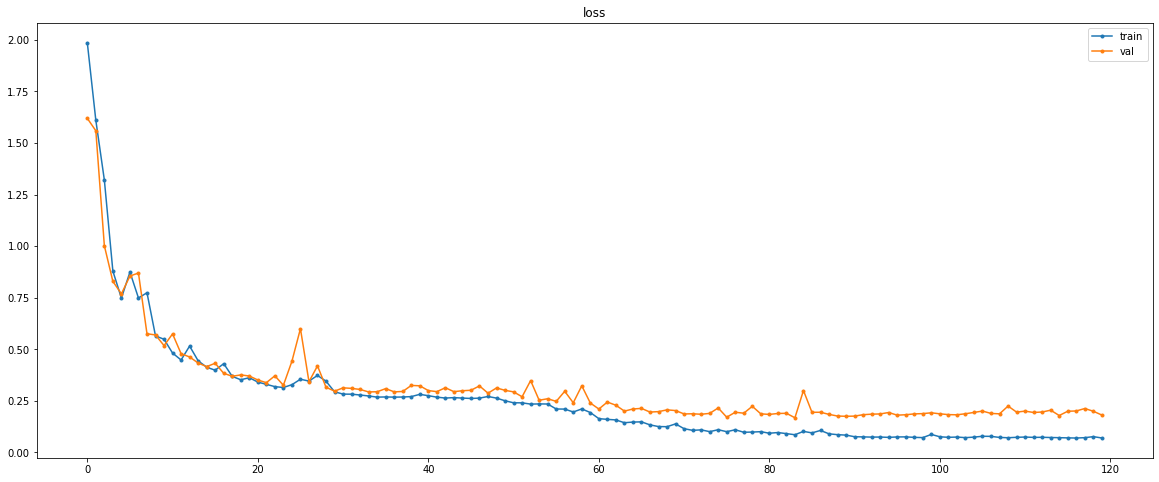

In [69]:
plt.figure(figsize=(20, 8))
plt.title("loss")
plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

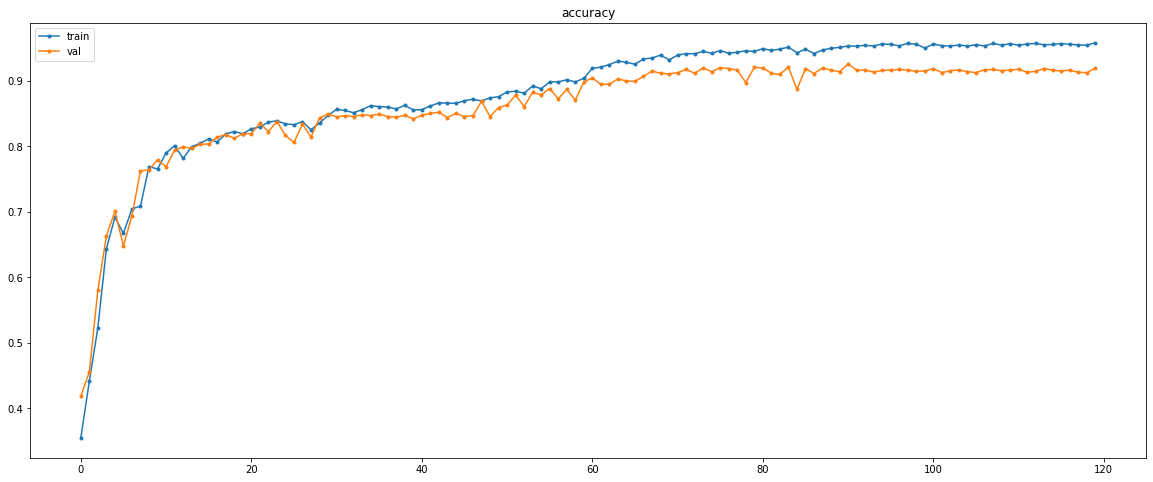

In [70]:
plt.figure(figsize=(20, 8))
plt.title("accuracy")
plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

# ----------------------------------------------------------------------------------------